Thanh Truc Bui

In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import pydot
import h5py
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz
from sklearn.metrics import matthews_corrcoef, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import optuna
import seaborn as sns

import joblib

load_dotenv() # load environment variables

abs_path_to_split30_fasta = os.getenv("FASTA_ENZYMES","not found")
abs_path_to_non_enzyme_fasta = os.getenv("FASTA_NON_ENZYMES","not found")
path_to_split100_fasta="/home/trucbui/PycharmProjects/PBL2324/venv/Dataset/rostlab.org_public_senoner_pbl_2023_split100.fasta.txt"


<font size="5">Read the protein mass table</font>

In [5]:

def read_mass_csv(path):  
    masses={}
    with open(path, "r") as file:
        for line in file:
            info = line.split("\t")
            char = info[0]
            mass = info[1]
            masses[char] = mass
    return masses

protein_masses=read_mass_csv(r'/home/trucbui/PBLGit/random_forest/mass.tsv')

def cal_mass(seq):
    mass = 0.0
    for char in seq:
        if char in protein_masses.keys():
            mass += float(protein_masses[char])
    mass = round(mass, 3)
    return mass


<font size="5">Create a protein class</font>

In [4]:

class Protein:
    def __init__(self, header, seq, is_enzyme):
        self.header = header
        self.seq=seq
        self.mass=cal_mass(seq)
        self.is_enzyme=is_enzyme
        self.embeddings=None
        self.emb_median=0.0
        self.emb_std=0.0
        self.emb_magnitude=0.0
        self.last_aa=seq[-1:]
        
        


<font size="5">Read data from fasta file</font>

In [6]:

def readfasta(fasta:str, is_enzyme:bool) -> dict: 
    seq_map=dict()
    enzyme=0
    if is_enzyme==True:
        enzyme=1
    with open(fasta, "r") as path:
        seq = ""
        header = path.readline().rstrip()[1:]
        for line in path.readlines():
            if line.startswith(">"):
                seq_map[header]=Protein(header,seq,enzyme)
                seq = ""
                header = line.rstrip()[1:]
            else:
                seq += line.rstrip()
        seq_map[header]=Protein(header,seq,enzyme)
    return seq_map


In [5]:

enzymes_map=readfasta(abs_path_to_split30_fasta,True)
non_enzymes_map=readfasta(abs_path_to_non_enzyme_fasta,False)
#enzymes_split100_map=readfasta(path_to_split100_fasta,True)


<font size="5">Read data from esm2 embeddings</font>

In [7]:
def magnitude(vector):
    return math.sqrt(sum(pow(element, 2) for element in vector))

In [8]:
def PCA_for_emb(emb:list,n:int):   #Reducing the embedding vector to n dimensions
    pca = PCA(n_components=n)
    emb_pca = pca.fit_transform(emb)
    return emb_pca


In [9]:

def read_esm2(path_to_esm2:str,seq_map:dict) -> dict: 
    protein_map=seq_map
    with h5py.File(path_to_esm2) as hdf_handle:
        for header, emb in hdf_handle.items():
            if header in seq_map.keys():
                protein_map[header].embeddings = a = np.array(list(emb))
                protein_map[header].emb_median=np.median(a)                
                protein_map[header].emb_std=np.std(a)
                protein_map[header].emb_magnitude=magnitude(a)

    return protein_map



In [9]:

enzymes_map = read_esm2(os.getenv("ESM2_ENZYMES_SPLIT_30"),enzymes_map)
non_enzymes_map = read_esm2(os.getenv("ESM2_NON_ENZYMES"),non_enzymes_map)


Pick the best n for the PCA

In [10]:
embs_enzymes=[]
embs_non_enzymes=[]

for protein in enzymes_map.keys():
    embs_enzymes.append(enzymes_map[protein].embeddings)
for protein in non_enzymes_map.keys():
    embs_non_enzymes.append(non_enzymes_map[protein].embeddings)



In [12]:

def pick_n_for_pca(embs, isEnzyme:bool):
    pca = PCA().fit(embs)
    plt.rcParams["figure.figsize"] = (12,6)

    fig, ax = plt.subplots()
    xi = np.arange(1, 2561, step=1)
    y = np.cumsum(pca.explained_variance_ratio_)

    n_components_90_percent = np.argmax(y >= 0.90) + 1


    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker='o', linestyle='--', color='#ff7f00')

    plt.xlabel('Number of Components')
    plt.xticks([256,512,700,1024,2048,2560])    
    plt.ylabel('Cumulative variance (%)')
    if (isEnzyme):
        plt.title('The number of components needed to explain variance-Enzymes')
    else:
        plt.title('The number of components needed to explain variance-Non Enzymes')

    plt.axhline(y=0.90, color='#377eb8', linestyle='-')
    plt.text(0.8, 0.85, '90% cut-off threshold', color = '#377eb8', fontsize=16)

    ax.grid(axis='x')
    plt.show()

    return n_components_90_percent


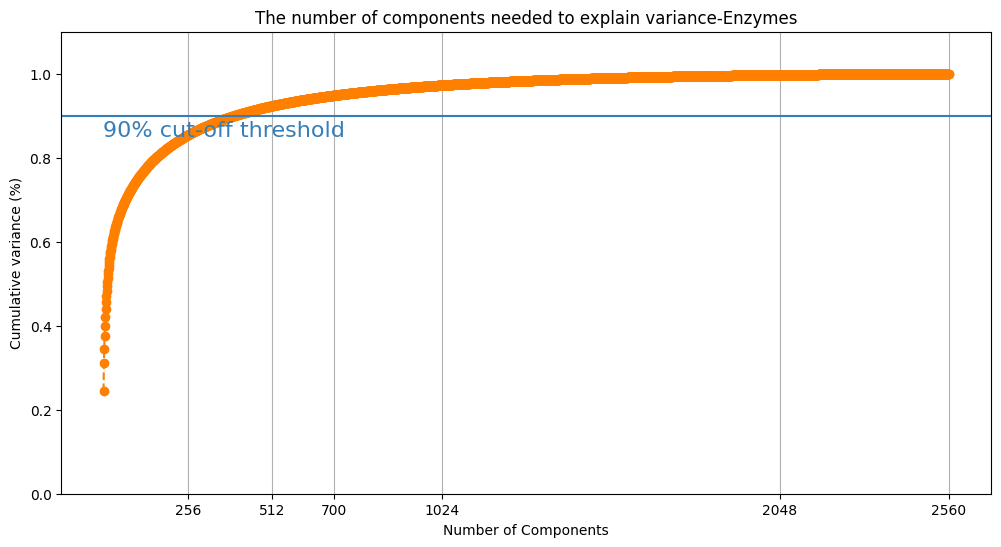

397

In [13]:

pick_n_for_pca(embs_enzymes,True)

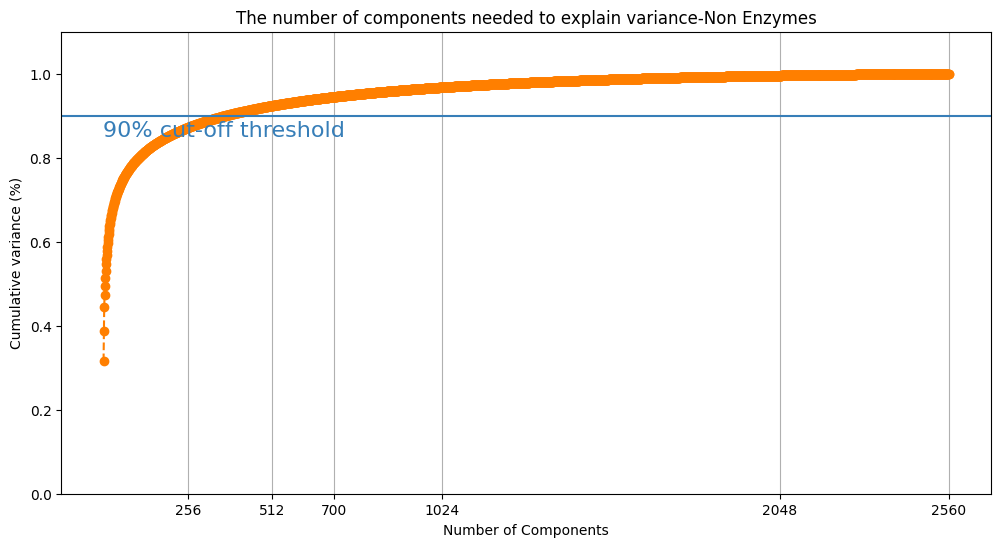

369

In [14]:
pick_n_for_pca(embs_non_enzymes,False)

Now that with n=700 we get 90% cut off, we choose PCA with 397 dimension

In [101]:
n_dimensions_after_pca=397

<font size="5">Create a dataframe<font>

In [10]:
def making_df(seq_map:dict)-> pd.DataFrame(): 
    headers=[]
    mass=[]
    labels=[]
    embs=[]
    emb_median_all=[]
    emb_std_all=[]
    emb_magnitude_all=[]
    seqs=[]
    
    
    for header in seq_map:
        headers.append(header)
        entry=seq_map[header]
        labels.append(entry.is_enzyme)
        mass.append(entry.mass)
        embs.append(entry.embeddings)
        emb_median_all.append(entry.emb_median)     
        emb_std_all.append(entry.emb_std)
        emb_magnitude_all.append(entry.emb_magnitude)
        seqs.append(entry.seq)
        
    emb_pca_all=PCA_for_emb(np.array(embs),n_dimensions_after_pca).tolist()

    
    return pd.DataFrame(data={'Label':labels ,'Entry':headers, 'Sequence':seqs ,'Mass':mass, 'Emb':embs, 'Emb median': emb_median_all, 
    'Emb std': emb_std_all, 'Emb magnitude': emb_magnitude_all, 'Emb PCA': emb_pca_all})


In [18]:

enzymes_df=making_df(enzymes_map)
enzymes_df=enzymes_df.sort_values(['Entry'],ascending=[True])

non_enzymes_df=making_df(non_enzymes_map)
non_enzymes_df=non_enzymes_df.sort_values(['Entry'],ascending=[True])

df=pd.concat([enzymes_df,non_enzymes_df],axis=0)
df=df.reset_index(drop=True)
print(df)


       Label       Entry                                           Sequence  \
0          1  A0A024RBG1  MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...   
1          1  A0A024SMV2  MASGNPYTLKWGIMATGGIAETFCKDLLCNPAIRGADDVRHEIVAV...   
2          1  A0A060S684  MRLPNLTLLVWAATSVGLVSALPQVSYKADATASAPTVKLHQGTVR...   
3          1  A0A075TXZ3  MQIINWASLLLVTWETVVAAELPIVDLGYQRHQAIGFNSTGRYYQF...   
4          1  A0A077K8G3  MLQMHSNSSFSPKCYYPLQHAGCVKTLQLPLTKVHGGLNRSESKNY...   
...      ...         ...                                                ...   
48701      0      X2JAU8  MQPPPRKGNYVKFLKNLHTEQVAKLQLKNQHECDLLEDIRQFTIKR...   
48702      0      X5HYT8  MASPGPAAGMQQKLEAAAAAAGGGDGAEWGRGMQKMEAVGAGGEGV...   
48703      0      X5LX76  MKYDMNHRKNSDDTPPASRTVKEMMAEFQNKLDDGDNRFRKQPPPP...   
48704      0      X6R8D5  MGRKEHESPSQPHMCGWEDSQKPSVPSHGPKTPSCKGVKAPHSSRP...   
48705      0      X6R8R1  MGVVLSPHPAPSRREPLAPLAPGTRPGWSPAVSGSSRSALRPSTAG...   

             Mass                                  

In [19]:
def filter_unwanted_seqs(df: pd.DataFrame) -> pd.DataFrame:
    """
    :param df: A dataframe containing either enzymes or non enzymes
    :param enzymes: If we pass a df containing enzymes we also need to filter out multifunctional enzymes
    :return: A filtered dataframe
    """

    # remove unwanted aas
    df = df[~df['Sequence'].str.contains('O')]
    df = df[~df['Sequence'].str.contains('U')]

    

    # remove sequences with length > 1022
   
    df = df[df["Sequence"].apply(len) <= 1022]

    return df

In [20]:
df=filter_unwanted_seqs(df)

In [21]:
df.to_csv(r'/home/trucbui/PBLGit/random_forest/split30_and_non_enzymes_with_esm2_df.csv', index = False)

PCA -> df

In [22]:
for i in range(n_dimensions_after_pca):
    df[f'PCA {i + 1}'] = df['Emb PCA'].apply(lambda x: x[i])
df

/tmp/ipykernel_30173/1299338572.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'PCA {i + 1}'] = df['Emb PCA'].apply(lambda x: x[i])
/tmp/ipykernel_30173/1299338572.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'PCA {i + 1}'] = df['Emb PCA'].apply(lambda x: x[i])
/tmp/ipykernel_30173/1299338572.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instea

,Label,Entry,Sequence,Mass,Emb,Emb median,Emb std,Emb magnitude,Emb PCA,PCA 1,...,PCA 388,PCA 389,PCA 390,PCA 391,PCA 392,PCA 393,PCA 394,PCA 395,PCA 396,PCA 397
0,1,A0A024RBG1,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,20403.292,"[-0.015143169, 0.035552002, -0.02231326, 0.002...",-0.003883,0.246559,12.475115,"[-0.7201105952262878, 0.1448676437139511, 0.30...",-0.720111,...,-0.006281,0.052287,0.046268,0.083181,0.050075,-0.054481,0.016427,-0.029164,-0.027066,-0.012487
1,1,A0A024SMV2,MASGNPYTLKWGIMATGGIAETFCKDLLCNPAIRGADDVRHEIVAV...,42741.490,"[0.059097216, -0.034141198, 0.061426997, 0.006...",-0.002613,0.224955,11.381984,"[1.1132575273513794, -0.09059920161962509, -0....",1.113258,...,0.061540,-0.065490,0.019377,-0.008375,-0.002246,-0.049017,0.024162,-0.040629,0.050864,-0.027723
2,1,A0A060S684,MRLPNLTLLVWAATSVGLVSALPQVSYKADATASAPTVKLHQGTVR...,63631.543,"[-0.016934631, -0.04490467, 0.0054878886, -0.0...",-0.002250,0.238975,12.091348,"[-0.14153902232646942, -0.16625456511974335, -...",-0.141539,...,0.031951,-0.058964,0.006235,-0.059419,0.063966,0.033733,0.039701,0.018552,0.046189,-0.034058
3,1,A0A075TXZ3,MQIINWASLLLVTWETVVAAELPIVDLGYQRHQAIGFNSTGRYYQF...,61430.846,"[-0.06815035, -0.034723807, 0.03341713, -0.057...",-0.001353,0.235385,11.909699,"[0.20521427690982819, -0.2543121576309204, -0....",0.205214,...,0.052293,-0.043375,0.026392,-0.057540,0.030957,0.033715,0.040280,0.059183,0.003765,0.023647
4,1,A0A077K8G3,MLQMHSNSSFSPKCYYPLQHAGCVKTLQLPLTKVHGGLNRSESKNY...,45202.778,"[-0.03639361, 0.046453245, 0.06140146, -0.0697...",-0.004369,0.246203,12.457084,"[-0.11231619119644165, 0.1939610093832016, 0.3...",-0.112316,...,-0.075562,0.043084,-0.002820,0.028949,0.001180,0.034455,0.061829,0.005027,-0.038367,0.042639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48698,0,W7MVT8,MAPPSVENGSDTSTAKRRRIALACNACRLRKSRCDGTRPSCSSCVS...,82857.088,"[0.023354042, -0.072173394, 0.041540354, -0.01...",-0.003120,0.234649,11.872498,"[0.9708402156829834, 0.43999868631362915, -0.2...",0.970840,...,0.037238,0.018326,0.012518,0.059115,0.045508,-0.016621,0.011483,0.066392,0.021532,0.056615
48699,0,W7X6T2,MDEYLENTNLEELEQECFMEDYQHEDVVEQENHQVDANDIYENQQM...,64066.442,"[0.0800108, 0.022337133, 0.0561253, 0.05279050...",-0.002872,0.270977,13.710601,"[-1.049216866493225, -0.6163782477378845, -1.1...",-1.049217,...,-0.051814,-0.011676,0.012553,0.047216,-0.015786,-0.006550,0.003418,-0.001565,-0.003699,-0.046536
48702,0,X5HYT8,MASPGPAAGMQQKLEAAAAAAGGGDGAEWGRGMQKMEAVGAGGEGV...,46670.171,"[0.0023819576, -0.033620838, 0.043625146, -0.0...",-0.003682,0.267518,13.535640,"[-0.8071576952934265, 0.28157609701156616, 0.4...",-0.807158,...,0.014853,0.044178,0.024309,0.032801,0.025218,-0.029518,-0.002020,0.003005,-0.035464,0.052918
48704,0,X6R8D5,MGRKEHESPSQPHMCGWEDSQKPSVPSHGPKTPSCKGVKAPHSSRP...,14504.182,"[-0.009083768, -0.058401734, 0.022719534, -0.0...",-0.004650,0.287314,14.537300,"[-2.6940054893493652, 2.3132126331329346, 0.50...",-2.694005,...,-0.018732,-0.020582,0.040025,-0.007314,0.001787,-0.004102,-0.009042,-0.014230,0.020489,0.023010


In [23]:
df.to_csv(r'/home/trucbui/PBLGit/random_forest/split30__and_non_enzymes_with_esm2_and_PCA_df.csv', index = False)

In [33]:
df=pd.read_csv(r'/home/trucbui/PBLGit/random_forest/split30__and_non_enzymes_with_esm2_and_PCA_df.csv')

Split data into training and validation sets

In [34]:
#Define the features and output:
y = df['Label']
# use 397 PCA components, mass and Emb magnitude as features 

X = df.drop(['Label','Entry', 'Sequence' ,'Emb','Emb PCA'],axis=1)

# X = df.drop(['Label','Entry','Emb', 'Emb median','Emb std','Emb PCA'],axis=1)
#X = df_with_enzyme_dup[['Mass', 'Emb magnitude']]

#Split data into train an test, with test size of 33%%:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.30,random_state=42)


Features selection

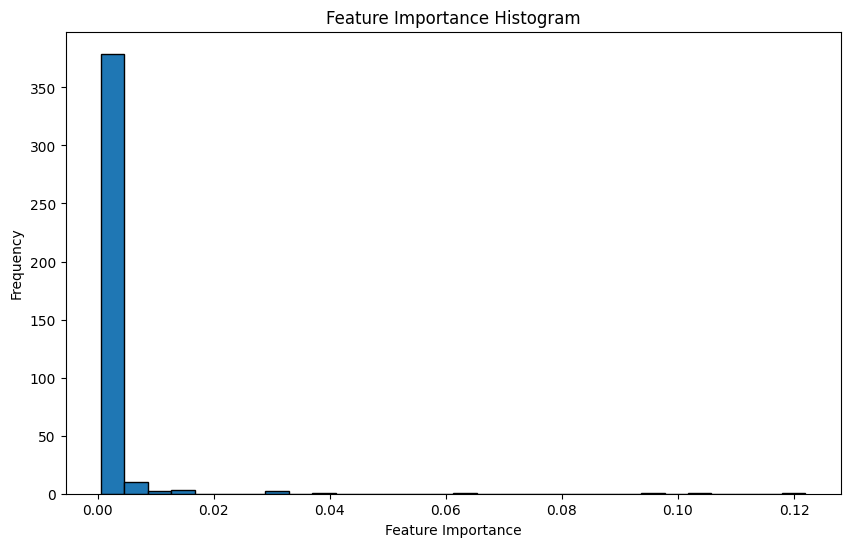

In [4]:
# Create a RandomForestClassifier with the desired parameters
clf = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=16, min_samples_leaf=8)

# Fit the classifier to your training data
clf.fit(X_train, y_train)

# Create a SelectFromModel instance with the trained classifier
sel = SelectFromModel(clf)

# Fit the SelectFromModel to your training data
sel.fit(X_train, y_train)

# Get the support for the selected features
selected_feat = X_train.columns[sel.get_support()]

# Get the feature importances
importances = clf.feature_importances_

# Create a histogram of feature importances
plt.figure(figsize=(10, 6))
plt.hist(importances, bins=30, edgecolor='k')
plt.xlabel('Feature Importance')
plt.ylabel('Frequency')
plt.title('Feature Importance Histogram')
plt.show()


Update X_train and X_val

In [5]:
selected_feat

Index(['Mass', 'Emb median', 'Emb std', 'Emb magnitude', 'PCA 1', 'PCA 2',
       'PCA 3', 'PCA 4', 'PCA 5', 'PCA 6', 'PCA 7', 'PCA 8', 'PCA 9', 'PCA 10',
       'PCA 11', 'PCA 12', 'PCA 13', 'PCA 14', 'PCA 15', 'PCA 16', 'PCA 17',
       'PCA 18', 'PCA 19', 'PCA 20', 'PCA 21', 'PCA 22', 'PCA 23', 'PCA 24',
       'PCA 25', 'PCA 26', 'PCA 27', 'PCA 28', 'PCA 30', 'PCA 32', 'PCA 33',
       'PCA 34', 'PCA 37', 'PCA 38', 'PCA 43', 'PCA 45', 'PCA 47'],
      dtype='object')

In [35]:
selected_feat = ['Mass', 'Emb median', 'Emb std', 'Emb magnitude', 'PCA 1', 'PCA 2',
       'PCA 3', 'PCA 4', 'PCA 5', 'PCA 6', 'PCA 7', 'PCA 8', 'PCA 9', 'PCA 10',
       'PCA 11', 'PCA 12', 'PCA 13', 'PCA 14', 'PCA 15', 'PCA 16', 'PCA 17',
       'PCA 18', 'PCA 19', 'PCA 20', 'PCA 21', 'PCA 22', 'PCA 23', 'PCA 24',
       'PCA 25', 'PCA 26', 'PCA 27', 'PCA 28', 'PCA 30', 'PCA 32', 'PCA 33',
       'PCA 34', 'PCA 37', 'PCA 38', 'PCA 43', 'PCA 45', 'PCA 47']

In [36]:
X_train=X_train[selected_feat]
X_train

,Mass,Emb median,Emb std,Emb magnitude,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,...,PCA 28,PCA 30,PCA 32,PCA 33,PCA 34,PCA 37,PCA 38,PCA 43,PCA 45,PCA 47
2346,60153.711,-0.002189,0.227337,11.502516,0.450330,0.056761,-0.152714,-0.562537,-0.342939,-0.214768,...,-0.008341,-0.258651,0.191711,-0.190431,0.198085,-0.056706,0.102702,0.001023,-0.073248,-0.050497
4468,81547.542,-0.002620,0.240143,12.150464,-0.087801,-0.501041,0.027421,-0.060358,-0.472940,-0.169462,...,-0.217000,0.013003,-0.066045,0.205444,-0.205213,0.000927,0.361068,-0.090677,0.137385,0.220343
4208,73156.055,-0.001840,0.243909,12.341031,-0.490790,0.191398,-0.227236,-0.447605,0.192044,-0.332910,...,-0.206891,0.011505,0.061020,0.280661,-0.190693,0.157721,0.061282,-0.073652,-0.035365,-0.020626
38073,16788.450,-0.003522,0.263979,13.356579,0.409453,-0.436421,0.680466,0.608248,-0.913846,-0.340269,...,0.084046,0.102708,-0.113404,0.029459,0.246531,-0.234006,0.081545,0.011106,0.189494,-0.053442
26079,17145.211,-0.004006,0.273501,13.838382,-1.157048,-0.699554,-1.003535,0.209268,-0.485984,0.239973,...,0.106651,-0.122736,-0.026281,0.101732,0.045860,-0.095990,-0.017414,0.108670,-0.043334,-0.066378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,38569.516,-0.002372,0.237258,12.004517,1.250809,0.068282,-0.679364,-0.326445,-0.044144,0.019516,...,0.117821,0.130882,0.084493,0.276278,0.121106,0.161477,0.145731,0.098911,0.110855,0.060580
44732,62801.437,-0.003409,0.240624,12.174803,1.049215,-0.032362,-0.520308,0.227688,-0.107257,0.025082,...,0.023508,0.166342,-0.079345,-0.089575,-0.221943,-0.054173,-0.066164,0.088127,0.042229,0.159788
38158,42719.902,-0.003696,0.260407,13.175781,-0.141801,-0.123650,-0.129375,0.378490,-0.209925,-0.149825,...,-0.228722,-0.014567,-0.002006,-0.079141,0.007258,-0.007409,0.216095,-0.144346,0.018872,0.012150
860,39507.175,-0.004268,0.227770,11.524400,1.324474,-0.121695,-0.079250,0.418808,0.021615,-0.275152,...,0.135837,-0.126808,0.186971,0.135583,0.140675,0.116276,0.035247,-0.023450,-0.019866,-0.119062


In [37]:
X_val=X_val[selected_feat]
X_val

,Mass,Emb median,Emb std,Emb magnitude,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,...,PCA 28,PCA 30,PCA 32,PCA 33,PCA 34,PCA 37,PCA 38,PCA 43,PCA 45,PCA 47
3288,53204.786,-0.002004,0.215373,10.897161,1.527525,0.479949,0.478415,-0.398979,-0.096541,0.008241,...,-0.407760,0.100937,-0.088920,0.000885,0.079751,0.080001,0.072033,0.054617,0.055674,0.014326
24569,13637.929,-0.005785,0.284015,14.370395,-2.632800,0.951098,-0.718454,-0.107533,-0.696173,0.829527,...,0.205180,-0.113088,0.138341,0.164172,0.063048,0.028840,-0.076273,0.279042,-0.006050,-0.130272
3227,21129.602,-0.003217,0.258557,13.082209,-1.394491,0.503702,0.221918,-0.067893,0.966157,0.197490,...,0.107544,0.232657,-0.390453,-0.045449,0.111651,0.115020,-0.142812,0.171152,0.120776,-0.059132
37150,77612.404,-0.004478,0.291372,14.742623,-2.854298,0.294258,-0.796443,0.159358,-0.262421,0.553211,...,-0.334029,0.048749,0.450789,0.083971,-0.195996,-0.086574,0.175382,-0.148632,-0.080607,0.033272
41612,15475.300,-0.002666,0.221602,11.212319,3.033358,1.507858,-0.043632,0.893096,-0.253952,0.470324,...,0.039842,0.156634,0.040273,-0.018722,-0.293254,-0.306046,-0.319269,-0.091802,0.310077,-0.214466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46030,27173.885,-0.002577,0.237180,12.000553,1.377973,-0.090564,-0.224595,-0.663383,0.162304,0.138842,...,0.056294,-0.182482,-0.029216,0.216935,-0.087679,0.020110,0.169415,-0.220669,0.004181,0.012636
29142,19516.227,-0.001920,0.225343,11.401598,4.076514,1.372917,0.113030,2.032609,-0.345690,0.178847,...,-0.203550,0.142170,0.063158,0.385542,0.364890,0.049251,-0.332787,0.035319,-0.036864,0.073229
35374,49180.210,-0.002846,0.276434,13.986732,-1.094648,-0.651709,-0.109749,0.108418,0.168941,0.136358,...,-0.132522,0.058307,-0.019114,-0.005593,-0.098823,-0.154915,-0.117023,-0.096477,-0.067527,0.084291
13063,17663.711,-0.004976,0.288347,14.589498,-1.927450,1.137897,0.910653,-0.033566,1.138596,-1.010688,...,-0.378974,-0.068893,-0.046958,0.223182,0.032359,0.004257,-0.164697,0.325442,0.302244,-0.152256


Duplicate the enzymes class to achieve a balanced dataframe

In [38]:
train_df = pd.concat([y_train, X_train], axis=1)
to_be_dupped = train_df['Label'] == 1

# Duplicate rows with label 1 and keep other rows unchanged
train_df_dup = pd.concat([train_df[to_be_dupped]] * 3, ignore_index=True)

# Concatenate rows with label 1 repeated four times with the original data
train_df_dup = pd.concat([train_df, train_df_dup], ignore_index=True)

# Split the data again into X_train_dup and y_train_dup
train_df_dup = train_df_dup.sort_values(by=['Label','Mass'], ascending=[False, True]).reset_index(drop=True)
y_train_dup = train_df_dup['Label']
X_train_dup = train_df_dup.drop(['Label'], axis=1)


In [39]:
train_df_dup

,Label,Mass,Emb median,Emb std,Emb magnitude,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,...,PCA 28,PCA 30,PCA 32,PCA 33,PCA 34,PCA 37,PCA 38,PCA 43,PCA 45,PCA 47
0,1,756.395,-0.003917,0.287661,14.554900,-2.756651,-0.491554,1.920434,-1.074907,0.318987,...,0.115981,0.067748,-0.045159,0.324130,-0.150512,0.255328,0.097106,-0.244107,-0.370295,0.160160
1,1,756.395,-0.003917,0.287661,14.554900,-2.756651,-0.491554,1.920434,-1.074907,0.318987,...,0.115981,0.067748,-0.045159,0.324130,-0.150512,0.255328,0.097106,-0.244107,-0.370295,0.160160
2,1,756.395,-0.003917,0.287661,14.554900,-2.756651,-0.491554,1.920434,-1.074907,0.318987,...,0.115981,0.067748,-0.045159,0.324130,-0.150512,0.255328,0.097106,-0.244107,-0.370295,0.160160
3,1,756.395,-0.003917,0.287661,14.554900,-2.756651,-0.491554,1.920434,-1.074907,0.318987,...,0.115981,0.067748,-0.045159,0.324130,-0.150512,0.255328,0.097106,-0.244107,-0.370295,0.160160
4,1,1807.104,-0.003616,0.278597,14.096272,-1.676045,-0.885849,-0.280739,0.389825,-1.206278,...,0.080077,0.343475,0.331616,0.072696,0.048416,0.158582,0.157396,-0.005621,-0.361526,-0.043862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51618,0,117254.293,-0.003186,0.256504,12.978298,0.910407,-0.187947,0.197846,1.189052,-0.509489,...,-0.063520,0.143776,0.067822,0.011583,-0.198705,0.009749,-0.124095,0.152382,-0.061788,0.125165
51619,0,117401.686,-0.002808,0.274783,13.903246,-0.358625,-0.741552,0.163000,0.844414,-1.243452,...,-0.056490,0.157380,-0.137316,-0.192145,-0.155210,0.105591,0.103659,-0.024771,-0.077011,0.037822
51620,0,117934.668,-0.002795,0.265583,13.437697,0.026389,-0.656690,-0.543371,0.923606,-0.585683,...,0.023976,0.252424,0.043277,-0.010173,-0.229948,0.070482,0.153217,0.086483,-0.035777,0.096671
51621,0,117970.059,-0.004446,0.288017,14.572891,-2.352534,-0.155872,-0.170447,0.180835,-0.388138,...,-0.155764,0.223001,-0.215555,0.012276,-0.142268,0.026066,-0.125735,-0.049395,-0.192245,-0.081454


In [40]:
y_train_dup

0        1
1        1
2        1
3        1
4        1
        ..
51618    0
51619    0
51620    0
51621    0
51622    0
Name: Label, Length: 51623, dtype: int64

In [41]:
X_train_dup

,Mass,Emb median,Emb std,Emb magnitude,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,...,PCA 28,PCA 30,PCA 32,PCA 33,PCA 34,PCA 37,PCA 38,PCA 43,PCA 45,PCA 47
0,756.395,-0.003917,0.287661,14.554900,-2.756651,-0.491554,1.920434,-1.074907,0.318987,-0.092934,...,0.115981,0.067748,-0.045159,0.324130,-0.150512,0.255328,0.097106,-0.244107,-0.370295,0.160160
1,756.395,-0.003917,0.287661,14.554900,-2.756651,-0.491554,1.920434,-1.074907,0.318987,-0.092934,...,0.115981,0.067748,-0.045159,0.324130,-0.150512,0.255328,0.097106,-0.244107,-0.370295,0.160160
2,756.395,-0.003917,0.287661,14.554900,-2.756651,-0.491554,1.920434,-1.074907,0.318987,-0.092934,...,0.115981,0.067748,-0.045159,0.324130,-0.150512,0.255328,0.097106,-0.244107,-0.370295,0.160160
3,756.395,-0.003917,0.287661,14.554900,-2.756651,-0.491554,1.920434,-1.074907,0.318987,-0.092934,...,0.115981,0.067748,-0.045159,0.324130,-0.150512,0.255328,0.097106,-0.244107,-0.370295,0.160160
4,1807.104,-0.003616,0.278597,14.096272,-1.676045,-0.885849,-0.280739,0.389825,-1.206278,-0.176399,...,0.080077,0.343475,0.331616,0.072696,0.048416,0.158582,0.157396,-0.005621,-0.361526,-0.043862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51618,117254.293,-0.003186,0.256504,12.978298,0.910407,-0.187947,0.197846,1.189052,-0.509489,-0.208010,...,-0.063520,0.143776,0.067822,0.011583,-0.198705,0.009749,-0.124095,0.152382,-0.061788,0.125165
51619,117401.686,-0.002808,0.274783,13.903246,-0.358625,-0.741552,0.163000,0.844414,-1.243452,-0.507070,...,-0.056490,0.157380,-0.137316,-0.192145,-0.155210,0.105591,0.103659,-0.024771,-0.077011,0.037822
51620,117934.668,-0.002795,0.265583,13.437697,0.026389,-0.656690,-0.543371,0.923606,-0.585683,-0.309467,...,0.023976,0.252424,0.043277,-0.010173,-0.229948,0.070482,0.153217,0.086483,-0.035777,0.096671
51621,117970.059,-0.004446,0.288017,14.572891,-2.352534,-0.155872,-0.170447,0.180835,-0.388138,0.540493,...,-0.155764,0.223001,-0.215555,0.012276,-0.142268,0.026066,-0.125735,-0.049395,-0.192245,-0.081454


Using Optuna for hyperparameter tuning

In [34]:
"""
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_depth": trial.suggest_int("max_depth", 2, 16),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 8, 128, step=10),
    }
    clf_optuna = RandomForestClassifier(**param)
    return cross_val_score(
        clf_optuna, X_train, y_train, n_jobs=-1, cv=3).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
"""

'\ndef objective(trial):\n    param = {\n        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),\n        "max_depth": trial.suggest_int("max_depth", 2, 16),\n        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 8, 128, step=10),\n    }\n    clf_optuna = RandomForestClassifier(**param)\n    return cross_val_score(\n        clf_optuna, X_train, y_train, n_jobs=-1, cv=3).mean()\n\nstudy = optuna.create_study(direction=\'maximize\')\nstudy.optimize(objective, n_trials=100)\n\ntrial = study.best_trial\n\nprint(\'Accuracy: {}\'.format(trial.value))\nprint("Best hyperparameters: {}".format(trial.params))\n'

In [12]:

#Build the model:
rf = RandomForestClassifier(max_depth=16, min_samples_leaf=8,n_estimators=200, random_state=42)


In [13]:
rf.fit(X_train_dup, y_train_dup)
y_pred=rf.predict(X_val)

<font size="5">Evaluate the model</font>

In [14]:
y_val=y_val.reset_index(drop=True)


In [38]:
y_val.to_csv(r'/home/trucbui/PBLGit/random_forest/y_val.csv', index = False)
X_val.to_csv(r'/home/trucbui/PBLGit/random_forest/X_val.csv', index = False)

In [39]:
y_pred

array([1, 0, 1, ..., 0, 0, 0])

Calculate Standard Error

In [39]:
def bootstrap_statistic_val_set(y_true, y_pred, statistic_func, B=10_000, alpha=0.05):
    bootstrap_scores = []
    for _ in range(B):
        indices = np.random.choice(len(y_pred), len(y_pred), replace=True)
        resampled_pred = y_pred[indices]
        resampled_true = y_true[indices]
        score,_ = statistic_func(resampled_true, resampled_pred)
        bootstrap_scores.append(score)

    mean_score = np.mean(bootstrap_scores)
    standard_error = np.std(bootstrap_scores, ddof=1)

    # Set the range of values you want to plot (e.g., between 0.70 and 0.74)
    min_value = 0.9
    max_value = 1.0

    # Filter data within the specified range
    filtered_data = [x for x in bootstrap_scores if min_value <= x <= max_value]

    # Create the histogram
    plt.hist(filtered_data, bins=20, edgecolor='black')

    # Set the title and labels
    # Set the background color to white
    plt.gca().set_facecolor('white')

    # Set the grid color to black
    plt.grid(color='lightgrey')
    plt.title('Close-up Distribution Plot')
    plt.xlabel('F1 score')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

    # Calculate the 95% confidence interval
    lower_bound = np.percentile(bootstrap_scores, (alpha / 2) * 100)
    upper_bound = np.percentile(bootstrap_scores, (1 - alpha / 2) * 100)

    return mean_score, standard_error, (lower_bound, upper_bound)



In [6]:

def round_to_significance(x, significance):
    if significance == 0.0:
        sig_position = 0
    else:
        sig_position = int(math.floor(math.log10(abs(significance))))
    return round(x, -sig_position), round(significance, -sig_position + 1)



In [5]:

def calculate_f1(y_true, y_pred):
    return f1_score(y_true, y_pred), "F1 score"

def calculate_mcc(y_true, y_pred):
    return matthews_corrcoef(y_true, y_pred), "MCC score"

def calculate_weighted_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted'), "Weighted F1-Score"


In [ ]:

initial_f1,_ = calculate_f1(y_val, y_pred)
mean_f1, se_f1, ci_95 = bootstrap_statistic_val_set(y_val, y_pred, calculate_f1)

rounded_mean_f1, rounded_se_f1 = round_to_significance(mean_f1, se_f1)

print(f" Binary Classification Random Forest:")
print(f"  - Initial F1 Score: {initial_f1:.2f}")
print(f"  - Mean ± SE: {rounded_mean_f1} ± {rounded_se_f1}")
print(f"  - 95% CI: [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")


In [49]:
# Generate random baseline predictions
n_samples = len(y_val)
random_baseline_predictions = np.random.choice(y_train_dup, n_samples)

# Calculate the accuracy of the random baseline predictions
baseline_accuracy = accuracy_score(y_val, random_baseline_predictions)

print("Baseline Accuracy (Random Guessing):", baseline_accuracy)
print("Model accuracy: %f" % accuracy_score(y_val, y_pred))

Baseline Accuracy (Random Guessing): 0.49641833810888253
Model accuracy: 0.994413


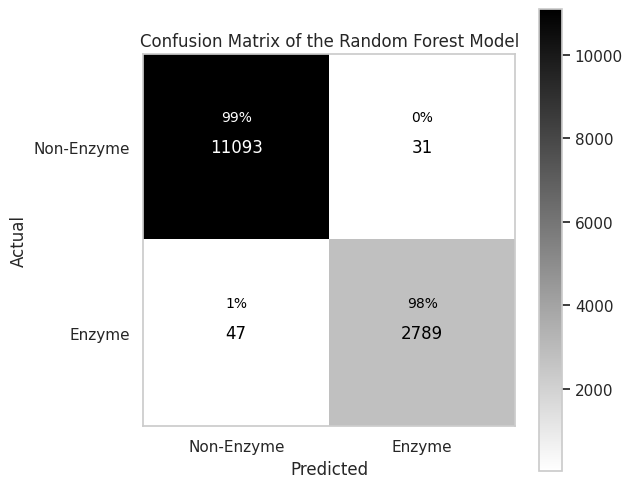

In [52]:
class_names = ["Non-Enzyme", "Enzyme"]
conf_matrix = confusion_matrix(y_val, y_pred)

# Calculate the percentages
cm_percentage = (conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]) * 100
cm_percentage = cm_percentage.round(2)

# Create a ConfusionMatrixDisplay without labels
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
cmd.plot(cmap="binary", ax=ax)
cax = ax

# Add the percentages as text annotations in the squares with specified ha and va
for i in range(2):
    for j in range(2):
        
        # Increase the vertical offset for the percentage text
        offset = 0.2
        text_color = cax.texts[i * 2 + j].get_color()
        ax.text(j, i - offset, f'{int(cm_percentage[i, j])}%', ha='center', va='top', color=text_color, fontsize=10, fontweight='light', zorder=4)
        
        
# Set the x and y labels
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)
ax.grid(False)
plt.title('Confusion Matrix of the Random Forest Model')

plt.show()


In [50]:
f1 = f1_score(y_val, y_pred, zero_division="warn")
print('F1 score:', f1)
mcc_score=matthews_corrcoef(y_val, y_pred)
print('MCC score:', mcc_score)
precision = precision_score(y_val, y_pred)
print(f"Precision = {precision}")
recall = recall_score(y_val, y_pred)
print(f"Recall = {recall}")


F1 score: 0.9862093352192361
MCC score: 0.9827121403967832
Precision = 0.9890070921985815
Recall = 0.9834273624823695


<font size="5">Make a tree</font>

In [17]:
rf_3 = RandomForestClassifier(max_depth=3, min_samples_leaf=8,n_estimators=200, random_state=42)
rf_3.fit(X_train_dup, y_train_dup)

tree = rf_3.estimators_[0]
# Export the image to a dot file:
export_graphviz(tree, out_file = r'/home/trucbui/PBLGit/random_forest/tree_esm2.dot', feature_names = X_train.columns, rounded = True, precision = 1)
# Use dot file to create a graph:
(graph, ) = pydot.graph_from_dot_file(r'/home/trucbui/PBLGit/random_forest/tree_esm2.dot')
# Write graph to a png file:
graph.write_png(r'/home/trucbui/PBLGit/random_forest/tree_rf_esm2.png')

In [18]:
y_pred_rf3=rf_3.predict(X_val)
f1 = f1_score(y_val, y_pred_rf3, zero_division="warn")
print('F1 score:', f1)
mcc_score=matthews_corrcoef(y_val, y_pred_rf3)
print('MCC score:', mcc_score)
precision = precision_score(y_val, y_pred_rf3)
print(f"Precision = {precision}")
recall = recall_score(y_val, y_pred_rf3)
print(f"Recall = {recall}")


F1 score: 0.5955417809035641
MCC score: 0.4983168739537191
Precision = 0.4498469295876103
Recall = 0.8808180535966149


<font size="5">Make a ROC curve</font>

ROC AUC Score: 0.99965037030951


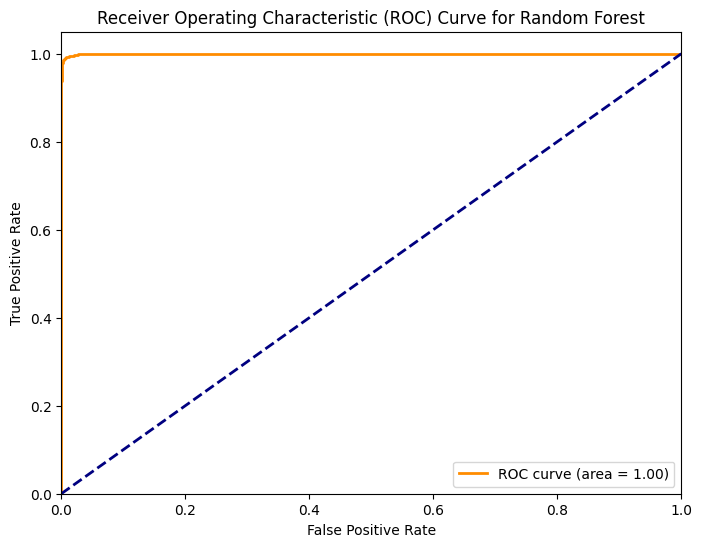

In [46]:
# Get predicted probabilities for the positive class
y_pred_prob = rf.predict_proba(X_val)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()

<font size="5">Save the model</font>

In [47]:
# file name, I'm using *.joblib as a file extension
filename = "/home/trucbui/PBLGit/random_forest/random_forest_esm2.joblib"

# save model
joblib.dump(rf, filename)


['/home/trucbui/PBLGit/random_forest/random_forest_esm2.joblib']

Test the model

In [8]:

# load model
loaded_model = joblib.load("/home/trucbui/PBLGit/random_forest/random_forest_esm2.joblib")

enzymes_test_fasta = '/home/trucbui/PycharmProjects/PBL2324/venv/Dataset/TestSet/all.fasta'
enzymes_test_esm2='/home/trucbui/PycharmProjects/PBL2324/venv/Dataset/TestSet/all_esm2_3b.h5'
non_enzymes_test_fasta = '/home/trucbui/PycharmProjects/PBL2324/venv/Dataset/TestSet/no_enzyme_test.fasta'
non_enzymes_test_esm2='/home/trucbui/PycharmProjects/PBL2324/venv/Dataset/TestSet/no_enzyme_test_esm2_3b.h5'


In [29]:

enzymes_test_map=readfasta(enzymes_test_fasta,True)
enzymes_test_map = read_esm2(enzymes_test_esm2,enzymes_test_map)
enzymes_test_df=making_df(enzymes_test_map)
non_enzymes_test_map=readfasta(non_enzymes_test_fasta,False)
non_enzymes_test_map = read_esm2(non_enzymes_test_esm2,non_enzymes_test_map)
non_enzymes_test_df=making_df(non_enzymes_test_map)
test_df=pd.concat([enzymes_test_df,non_enzymes_test_df],axis=0).reset_index(drop=True)
test_df


,Label,Entry,Sequence,Mass,Emb,Emb median,Emb std,Emb magnitude,Emb PCA
0,1,A7KH27,MTTSGHTSFSDYSPRRRSMLLGGLGGAAALSAAGFTGMASASPRGS...,58146.944,"[0.045319334, -0.0633503, 0.049435206, -0.0617...",-0.002857,0.249266,12.612103,"[-1.3552238941192627, -0.5720860362052917, 0.1..."
1,1,A0A0F7N9T7,MTTGHSPVSGFSPRRRSLLIGGASAAALLPLGHAGTAAAAEGGKAA...,57351.406,"[0.04066258, -0.06218778, 0.05035584, -0.05342...",-0.002895,0.249735,12.635798,"[-1.3813239336013794, -0.5872467756271362, 0.1..."
2,1,A0A559V0A1,MTTSGSSSVPGFSPRRRSLLLGGGSAAALTALGHAGTAAAEPGPAA...,56139.178,"[0.029930845, -0.047064256, 0.040307645, -0.05...",-0.002320,0.249264,12.612007,"[-1.2500011920928955, -0.6739264726638794, 0.2..."
3,1,A0A559V0T8,MTSGNSSSAGFSPARRSLLLGGASTAALATLGTGTAAAAGQGTGPA...,56600.127,"[0.051781543, -0.062385045, 0.03530182, -0.064...",-0.001902,0.247109,12.502918,"[-1.1742753982543945, -0.6050054430961609, 0.1..."
4,1,A8CF74,MTAAYLKTAFGDRLSITVVESSRIGTIGVGEATFSDIQHFFQFLNL...,57074.215,"[-0.030194182, 0.012060913, 0.0017601552, -0.0...",-0.002596,0.238864,12.085786,"[-0.6824474334716797, -0.6513224840164185, -0...."
...,...,...,...,...,...,...,...,...,...
10449,0,A6ZR60,MYSNHNLNSDDCCFDWNEEKAAELQRTGVSFDRSLTPQSLRTSTRR...,24379.575,"[-0.04077466, -0.0042249197, 0.033451386, 0.03...",-0.004387,0.292543,14.801898,"[-2.0994811058044434, -0.8043941259384155, 0.0..."
10450,0,Q83AR2,MSRLPSKTKYHSSHRSLNRKTPLLQRSSETNSLRESGIETASSQLS...,53824.385,"[0.06793185, -0.008874888, -0.017917404, 0.001...",-0.003839,0.287762,14.559941,"[-2.259028673171997, -0.07760342210531235, -0...."
10451,0,Q2V3J0,MGFKNNLSLVSVMVFALILLPMISGQTMQCYSGIACTDDGTCNDYC...,9649.455,"[0.06745284, -0.049419448, 0.0644797, -0.07348...",-0.002881,0.265730,13.445131,"[-0.5941745042800903, -0.3381393551826477, -0...."
10452,0,P85463,SANAKNDFMRF,1281.592,"[0.05350041, 0.033236418, -0.028257918, -0.015...",-0.001077,0.280476,14.191294,"[-0.5181512832641602, -0.745238184928894, 0.47..."


In [31]:
test_df=test_df.sort_values(['Label','Entry'],ascending=[False, True])
for i in range(n_dimensions_after_pca):
    test_df[f'PCA {i + 1}'] = test_df['Emb PCA'].apply(lambda x: x[i])
test_df


,Label,Entry,Sequence,Mass,Emb,Emb median,Emb std,Emb magnitude,Emb PCA,PCA 1,...,PCA 388,PCA 389,PCA 390,PCA 391,PCA 392,PCA 393,PCA 394,PCA 395,PCA 396,PCA 397
94,1,A0A011QK89,MESIEAVVIGAGVVGLACARELARRGFETVILERHGAFGTETSARN...,40497.001,"[-0.0019319912, -0.016816322, 0.028769402, -0....",-0.002018,0.223793,11.323197,"[0.8658735156059265, -0.8132790327072144, -0.3...",0.865874,...,-0.019424,0.003986,0.011808,-0.018364,-0.000313,0.016770,-0.011104,-0.009718,-0.012001,0.031883
33,1,A0A059WF38,MDKPIIAYLSDIGNHDEAHALGKGLIKTIAPGAEIVDITHQVTPFD...,28233.770,"[0.0055492446, 0.016777404, -0.03134609, -0.03...",-0.002754,0.244104,12.350880,"[-0.8927932977676392, -0.880335807800293, -0.3...",-0.892793,...,-0.003286,-0.000245,-0.003771,0.000451,0.012550,0.011128,-0.019105,-0.005390,0.009546,0.008515
302,1,A0A067XR63,MNAEGGNLHREFEITWGDGRARIHNNGGLLTLSLDRASGSGFRSKN...,30796.835,"[-0.05900694, 0.019138305, 0.005838026, -0.002...",-0.002315,0.242572,12.273351,"[-1.1098041534423828, -0.1795676052570343, 0.5...",-1.109804,...,0.004330,-0.005786,-0.009632,-0.005120,-0.003335,0.009079,0.005338,0.001687,0.005976,-0.007075
294,1,A0A067XRK9,MASSLTLPMAMAFTLLALSFASAMGGSMNSSRFDELFQPSWAFDHF...,33724.077,"[-0.055320676, 0.0015649835, 0.06592601, -0.04...",-0.002057,0.249882,12.643257,"[-1.4481911659240723, -0.2764866054058075, 0.4...",-1.448191,...,-0.021995,0.008010,0.031029,0.018960,-0.009500,-0.012053,-0.001305,0.006941,0.016045,0.010640
303,1,A0A067YMX8,MAASPYSIFAVQLLLLASWMLSSSSSNFNQDFNIAWGGGRARILNN...,32487.228,"[-0.05380216, 0.0067072976, 0.035263997, -0.03...",-0.002104,0.244987,12.395542,"[-1.153989315032959, -0.16305990517139435, 0.4...",-1.153989,...,0.028690,-0.000107,-0.023278,0.001426,0.001578,-0.003391,0.016743,-0.010656,-0.003679,-0.005281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7433,0,W2PDG1,MKSFLIAIVIAVLLPVSAADFCAQWRLSKAGKYIIYNNLWNQNTAT...,25510.828,"[0.033741392, 0.053279333, -0.056721542, -0.05...",-0.002122,0.243228,12.306490,"[1.5100021362304688, -0.44248831272125244, -0....",1.510002,...,-0.035143,-0.010653,-0.021729,-0.008067,0.107434,0.004329,0.039126,0.054245,0.017108,-0.022644
6141,0,W4VSH9,MNFELIYVSSLLLGICLANQADVVPSDCNLPADAGMCYAYFPMFFY...,19243.713,"[0.020676099, -0.003858359, -0.087140284, -0.0...",-0.003511,0.243193,12.304819,"[0.5215532779693604, 0.0703187808394432, -0.21...",0.521553,...,-0.002987,-0.029522,0.033533,-0.037501,0.038460,0.023397,0.010218,0.017738,-0.030926,-0.001563
3407,0,W5U5X5,MKALYLLGLLAFLYSCSSENVYDLQPESSEEENPGTFLEAIQEQSR...,20317.651,"[0.07092074, -0.02695332, 0.029215096, -0.0391...",-0.003557,0.271204,13.722124,"[-0.7907848954200745, -0.5922244787216187, 0.0...",-0.790785,...,-0.009304,-0.009243,0.005600,-0.014352,-0.002801,-0.044681,0.024740,-0.020552,-0.027833,0.006811
7046,0,W5XKT8,MALLALASAVPSALLALAVFRVPAWACLLCFTTYSERLRICQMFVG...,36291.238,"[0.04543773, -0.08296901, -0.016205797, -0.039...",-0.003594,0.241647,12.226573,"[2.341522693634033, 0.060745712369680405, 0.92...",2.341523,...,0.019953,-0.000024,-0.000148,-0.041962,0.028815,-0.004895,0.022940,-0.032018,-0.084004,0.040736


In [37]:
test_df_reduced_pca=test_df[['Label', 'Entry', 'Sequence', 'Mass', 'Emb median', 'Emb std', 'Emb magnitude', 'PCA 1', 'PCA 2',
       'PCA 3', 'PCA 4', 'PCA 5', 'PCA 6', 'PCA 7', 'PCA 8', 'PCA 9', 'PCA 10',
       'PCA 11', 'PCA 12', 'PCA 13', 'PCA 14', 'PCA 15', 'PCA 16', 'PCA 17',
       'PCA 18', 'PCA 19', 'PCA 20', 'PCA 21', 'PCA 22', 'PCA 23', 'PCA 24',
       'PCA 25', 'PCA 26', 'PCA 27', 'PCA 28', 'PCA 30', 'PCA 32', 'PCA 33',
       'PCA 34', 'PCA 37', 'PCA 38', 'PCA 43', 'PCA 45', 'PCA 47']]
test_df_reduced_pca

,Label,Entry,Sequence,Mass,Emb median,Emb std,Emb magnitude,PCA 1,PCA 2,PCA 3,...,PCA 28,PCA 30,PCA 32,PCA 33,PCA 34,PCA 37,PCA 38,PCA 43,PCA 45,PCA 47
94,1,A0A011QK89,MESIEAVVIGAGVVGLACARELARRGFETVILERHGAFGTETSARN...,40497.001,-0.002018,0.223793,11.323197,0.865874,-0.813279,-0.366088,...,0.582900,-0.062824,0.385040,0.026210,-0.309930,-0.038251,0.108171,-0.143039,0.141340,-0.271395
33,1,A0A059WF38,MDKPIIAYLSDIGNHDEAHALGKGLIKTIAPGAEIVDITHQVTPFD...,28233.770,-0.002754,0.244104,12.350880,-0.892793,-0.880336,-0.323113,...,-0.074740,0.037376,-0.199919,0.135717,0.111076,-0.091574,-0.340030,-0.221089,-0.025152,0.147661
302,1,A0A067XR63,MNAEGGNLHREFEITWGDGRARIHNNGGLLTLSLDRASGSGFRSKN...,30796.835,-0.002315,0.242572,12.273351,-1.109804,-0.179568,0.550073,...,0.027012,-0.186748,-0.352111,-0.274968,0.047613,-0.043934,-0.232422,-0.015948,0.031514,-0.172354
294,1,A0A067XRK9,MASSLTLPMAMAFTLLALSFASAMGGSMNSSRFDELFQPSWAFDHF...,33724.077,-0.002057,0.249882,12.643257,-1.448191,-0.276487,0.432441,...,0.073912,-0.222840,-0.388385,-0.190431,0.024492,-0.042332,-0.162379,0.022120,-0.065284,-0.074855
303,1,A0A067YMX8,MAASPYSIFAVQLLLLASWMLSSSSSNFNQDFNIAWGGGRARILNN...,32487.228,-0.002104,0.244987,12.395542,-1.153989,-0.163060,0.437810,...,0.061944,-0.207301,-0.364656,-0.241466,-0.021518,-0.053437,-0.255435,-0.000024,0.003016,-0.118526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7433,0,W2PDG1,MKSFLIAIVIAVLLPVSAADFCAQWRLSKAGKYIIYNNLWNQNTAT...,25510.828,-0.002122,0.243228,12.306490,1.510002,-0.442488,-0.250065,...,-0.295734,-0.070110,0.228628,0.156005,0.116332,-0.106942,-0.351613,-0.079449,-0.273802,-0.125418
6141,0,W4VSH9,MNFELIYVSSLLLGICLANQADVVPSDCNLPADAGMCYAYFPMFFY...,19243.713,-0.003511,0.243193,12.304819,0.521553,0.070319,-0.215755,...,0.245631,0.132581,-0.012852,0.272221,-0.120323,-0.167498,0.156871,-0.179426,-0.032825,0.056171
3407,0,W5U5X5,MKALYLLGLLAFLYSCSSENVYDLQPESSEEENPGTFLEAIQEQSR...,20317.651,-0.003557,0.271204,13.722124,-0.790785,-0.592224,0.057076,...,0.144902,0.162765,0.182106,0.008402,0.106958,0.025463,0.018514,-0.030416,0.001169,0.027862
7046,0,W5XKT8,MALLALASAVPSALLALAVFRVPAWACLLCFTTYSERLRICQMFVG...,36291.238,-0.003594,0.241647,12.226573,2.341523,0.060746,0.928005,...,-0.111065,0.150978,0.154511,-0.054656,-0.204488,-0.164061,-0.000078,-0.006800,-0.073930,-0.065843


In [38]:
test_df_reduced_pca.to_csv(r'/home/trucbui/PBLGit/random_forest/test_set_df_for_rf_reduced_pca.csv', index = False)

In [133]:
test_df_reduced_pca=pd.read_csv(r'/home/trucbui/PBLGit/random_forest/test_set_df_for_rf_reduced_pca.csv')

In [5]:
y_test=test_df_reduced_pca['Label']
X_test=test_df_reduced_pca[['Mass', 'Emb median', 'Emb std', 'Emb magnitude', 'PCA 1', 'PCA 2',
       'PCA 3', 'PCA 4', 'PCA 5', 'PCA 6', 'PCA 7', 'PCA 8', 'PCA 9', 'PCA 10',
       'PCA 11', 'PCA 12', 'PCA 13', 'PCA 14', 'PCA 15', 'PCA 16', 'PCA 17',
       'PCA 18', 'PCA 19', 'PCA 20', 'PCA 21', 'PCA 22', 'PCA 23', 'PCA 24',
       'PCA 25', 'PCA 26', 'PCA 27', 'PCA 28', 'PCA 30', 'PCA 32', 'PCA 33',
       'PCA 34', 'PCA 37', 'PCA 38', 'PCA 43', 'PCA 45', 'PCA 47']]


In [234]:

y_pred_test=loaded_model.predict(X_test)

loaded_model_accuracy = loaded_model.score(X_test, y_test)
print("Loaded Model Accuracy:" , loaded_model_accuracy)

f1_test = f1_score(y_test, y_pred_test, zero_division="warn")
print('F1 score:', f1_test)

weighted_f1_test,_ = calculate_weighted_f1(y_test, y_pred_test)
print("Weighted F1 score:", weighted_f1_test)

mcc_test=matthews_corrcoef(y_test, y_pred_test)
print('MCC score:', mcc_test)

precision_test = precision_score(y_test, y_pred_test)
print(f"Precision = {precision_test}")

recall_test = recall_score(y_test, y_pred_test)
print(f"Recall = {recall_test}")

Loaded Model Accuracy: 0.9754161086665392
F1 score: 0.8042650418888042
Weighted F1 score: 0.9767874134628699
MCC score: 0.7978572753152363
Precision = 0.7183673469387755
Recall = 0.9134948096885813


In [29]:
y_train_dup.to_csv(r'/home/trucbui/PBLGit/random_forest/y_train.csv', index = False)

In [32]:
y_train_dup = pd.read_csv(r'/home/trucbui/PBLGit/random_forest/y_train.csv')

In [235]:
n_samples_random_baseline_test = len(y_test)
random_baseline_predictions_test = np.random.choice(np.array(y_train_dup).flatten(), n_samples_random_baseline_test)

baseline_accuracy_test = accuracy_score(y_test, random_baseline_predictions_test)
baseline_mcc_test=matthews_corrcoef(y_test, random_baseline_predictions_test)
baseline_f1_test=f1_score(y_test, random_baseline_predictions_test, zero_division="warn")
baseline_weighted_f1_test,_=calculate_weighted_f1(y_test, random_baseline_predictions_test)
baseline_precsion_test=precision_score(y_test, random_baseline_predictions_test)
baseline_recall_test=recall_score(y_test, random_baseline_predictions_test)

print("Baseline Accuracy (Random Guessing):", baseline_accuracy_test)
print("Baseline F1 (Random Guessing):", baseline_f1_test)
print("Baseline Weighted F1 (Random Guessing):", baseline_weighted_f1_test)
print("Baseline MCC (Random Guessing):", baseline_mcc_test)
print("Baseline Precision (Random Guessing):", baseline_precsion_test)
print("Baseline Recall (Random Guessing):", baseline_recall_test)

Baseline Accuracy (Random Guessing): 0.4984694853644538
Baseline F1 (Random Guessing): 0.09494217158639738
Baseline Weighted F1 (Random Guessing): 0.6222641366372853
Baseline MCC (Random Guessing): -0.011163985479644175
Baseline Precision (Random Guessing): 0.052732502396931925
Baseline Recall (Random Guessing): 0.4757785467128028


/tmp/ipykernel_147158/1512944586.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(categories, rotation=45, horizontalalignment='right')


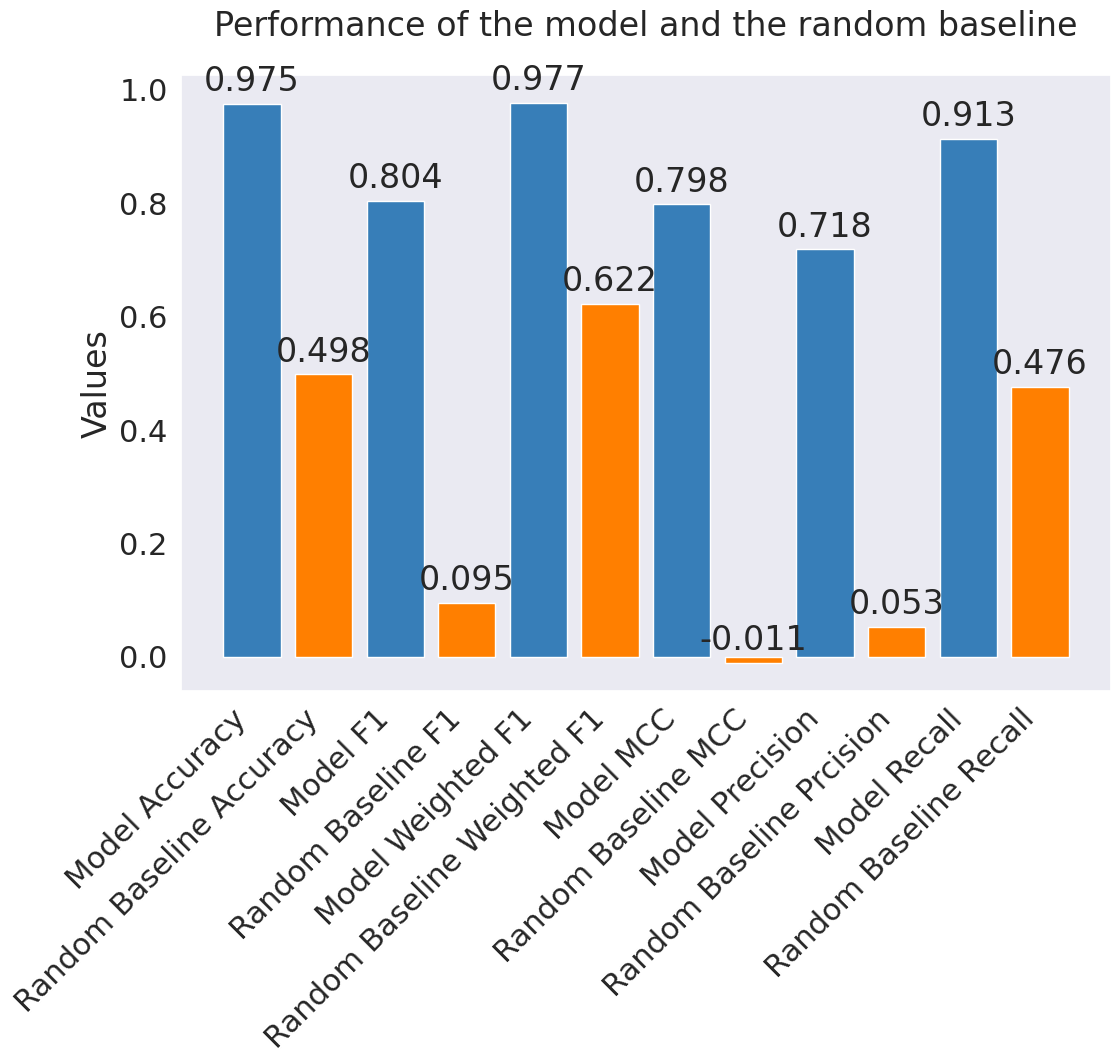

In [237]:
# Plot the results of the model and the random baseline
# Showing accuracy, f1, mcc, precision and recall
categories = ['Model Accuracy','Random Baseline Accuracy' ,'Model F1','Random Baseline F1','Model Weighted F1','Random Baseline Weighted F1','Model MCC','Random Baseline MCC' ,'Model Precision','Random Baseline Prcision' ,'Model Recall', 'Random Baseline Recall']
values = [loaded_model_accuracy, baseline_accuracy_test, f1_test, baseline_f1_test,weighted_f1_test, baseline_weighted_f1_test ,mcc_test, baseline_mcc_test, precision_test, baseline_precsion_test, recall_test, baseline_recall_test]

plt.figure(figsize=(12, 8))
# Create a bar plot
plt.bar(categories, values,color=['#377eb8', '#ff7f00','#377eb8', '#ff7f00','#377eb8', '#ff7f00','#377eb8', '#ff7f00','#377eb8', '#ff7f00'])

# Rotate the category labels for better readability
plt.gca().set_xticklabels(categories, rotation=45, horizontalalignment='right')

# Add values on top of each bar
for i, v in enumerate(values):
    plt.text(i, v + 0.01, str(round(v, 3)), ha='center', va='bottom')

plt.ylabel('Values')
plt.title('Performance of the model and the random baseline',y=1.05)
#plt.tight_layout()
plt.grid(False)
plt.show()


In [28]:
def bootstrap_statistic_test_set(y_true, y_pred, statistic_func, B=10_000, alpha=0.05):
    bootstrap_scores = []
    for _ in range(B):
        indices = np.random.choice(len(y_pred), len(y_pred), replace=True)
        resampled_pred = y_pred[indices]
        resampled_true = y_true[indices]
        score,metric_name= statistic_func(resampled_true, resampled_pred)
        bootstrap_scores.append(score)

    mean_score = np.mean(bootstrap_scores)
    standard_error = np.std(bootstrap_scores, ddof=1)

    # Set the range of values you want to plot (e.g., between 0.70 and 0.74)
    min_value = 0.7
    max_value = 0.9

    # Filter data within the specified range
    filtered_data = [x for x in bootstrap_scores if min_value <= x <= max_value]

    # Create the histogram
    plt.hist(filtered_data, bins=20, edgecolor='black')

    # Set the title and labels
    # Set the background color to white
    plt.gca().set_facecolor('white')

    # Set the grid color to black
    #plt.grid(color='lightgrey')
    plt.grid(False)
    plt.title('Close-up Distribution Plot')
    plt.xlabel(metric_name)
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

    # Calculate the 95% confidence interval
    lower_bound = np.percentile(bootstrap_scores, (alpha / 2) * 100)
    upper_bound = np.percentile(bootstrap_scores, (1 - alpha / 2) * 100)

    return mean_score, standard_error, (lower_bound, upper_bound)


SE for f1-score

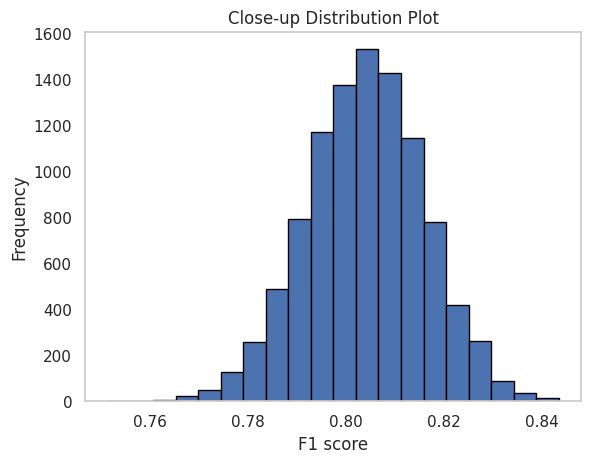

 Binary Classification Random Forest:
  - Initial F1 Score: 0.80
  - Mean ± SE: 0.8 ± 0.012
  - 95% CI: [0.78, 0.83]


In [53]:
#IDK if this is necessary or not

initial_f1_test,_ = calculate_f1(y_test, y_pred_test)
mean_f1_test, se_f1_test, ci_95_test = bootstrap_statistic_test_set(y_test, y_pred_test, calculate_f1)

rounded_mean_f1_test, rounded_se_f1_test = round_to_significance(mean_f1_test, se_f1_test)

print(f" Binary Classification Random Forest:")
print(f"  - Initial F1 Score: {initial_f1_test:.2f}")
print(f"  - Mean ± SE: {rounded_mean_f1_test} ± {rounded_se_f1_test}")
print(f"  - 95% CI: [{ci_95_test[0]:.2f}, {ci_95_test[1]:.2f}]")

SE for MCC-score

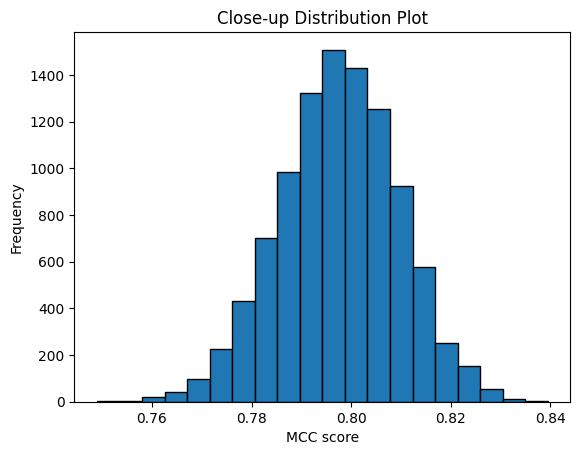

 Binary Classification Random Forest:
  - Initial MCC Score: 0.80
  - Mean ± SE: 0.8 ± 0.012
  - 95% CI: [0.77, 0.82]


In [29]:
initial_mcc_test,_ = calculate_mcc(y_test, y_pred_test)
mean_mcc_test, se_mcc_test, ci_95_test = bootstrap_statistic_test_set(y_test, y_pred_test, calculate_mcc)

rounded_mean_mcc_test, rounded_se_mcc_test = round_to_significance(mean_mcc_test, se_mcc_test)

print(f" Binary Classification Random Forest:")
print(f"  - Initial MCC Score: {initial_mcc_test:.2f}")
print(f"  - Mean ± SE: {rounded_mean_mcc_test} ± {rounded_se_mcc_test}")
print(f"  - 95% CI: [{ci_95_test[0]:.2f}, {ci_95_test[1]:.2f}]")

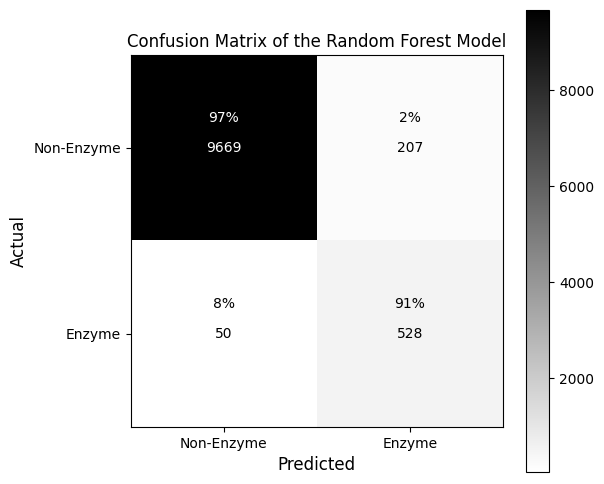

In [10]:
class_names = ["Non-Enzyme", "Enzyme"]
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Calculate the percentages
cm_percentage = (conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]) * 100
cm_percentage = cm_percentage.round(2)

# Create a ConfusionMatrixDisplay without labels
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))

#heatmap = sns.heatmap(cm_percentage, annot=False, fmt=".2f", cmap="binary", cbar=False)


cmd.plot(cmap="binary", ax=ax)
cax = ax

# Add the percentages as text annotations in the squares with specified ha and va
for i in range(2):
    for j in range(2):
        
        # Increase the vertical offset for the percentage text
        offset = 0.2
        text_color = cax.texts[i * 2 + j].get_color()
        ax.text(j, i - offset, f'{int(cm_percentage[i, j])}%', ha='center', va='top', color=text_color, fontsize=10, fontweight='light', zorder=4)
        
        
# Set the x and y labels
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)
ax.grid(False)


plt.title('Confusion Matrix of the Random Forest Model')
plt.show()

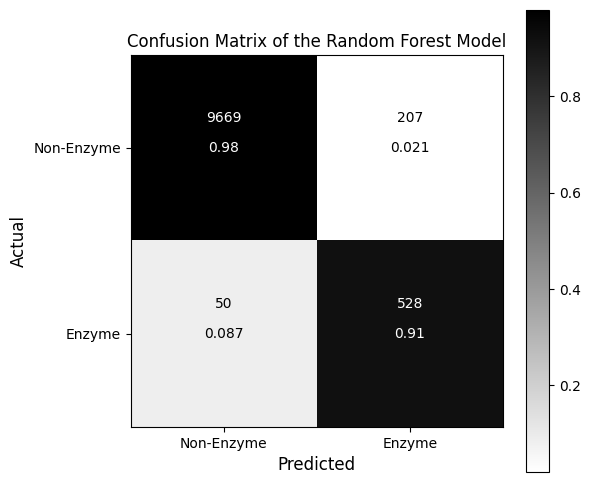

In [47]:
class_names = ["Non-Enzyme", "Enzyme"]
conf_matrix = confusion_matrix(y_test, y_pred_test, normalize='true')

cm_real_number = confusion_matrix(y_test, y_pred_test)


# Create a ConfusionMatrixDisplay without labels
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))

#heatmap = sns.heatmap(cm_percentage, annot=False, fmt=".2f", cmap="binary", cbar=False)


cmd.plot(cmap="binary", ax=ax)
cax = ax

# Add the percentages as text annotations in the squares with specified ha and va
for i in range(2):
    for j in range(2):
        
        # Increase the vertical offset for the percentage text
        offset = 0.2
        text_color = cax.texts[i * 2 + j].get_color()
        ax.text(j, i - offset, f'{int(cm_real_number[i, j])}', ha='center', va='top', color=text_color, fontsize=10, fontweight='light', zorder=4)
        
        
# Set the x and y labels
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)
ax.grid(False)


plt.title('Confusion Matrix of the Random Forest Model')
plt.show()

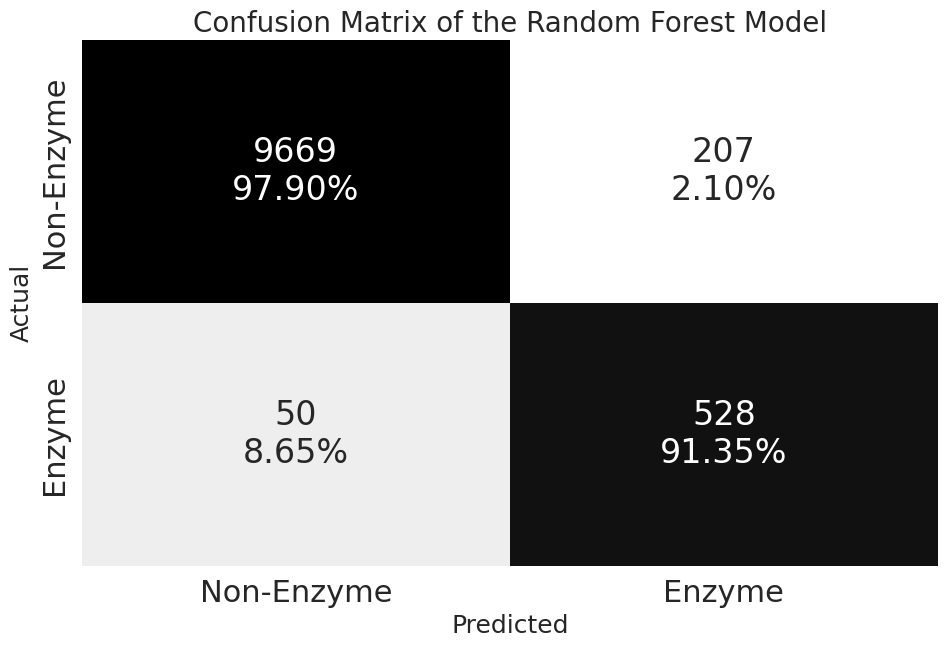

In [89]:
cf_matrix = confusion_matrix(y_test, y_pred_test)
cf_matrix_normal = confusion_matrix(y_test, y_pred_test, normalize='true')
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_normal.flatten()]
labels = [f"{v2}\n{v3}" for v2, v3 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(cf_matrix_normal, annot=labels, fmt="", cmap="binary", cbar=False, xticklabels=['Non-Enzyme', 'Enzyme'], yticklabels=['Non-Enzyme', 'Enzyme'])

sns.set(font_scale=2)
plt.xlabel("Predicted", fontsize=18)
plt.ylabel("Actual", fontsize=18)

plt.title('Confusion Matrix of the Random Forest Model', fontsize=20)
plt.tight_layout()
plt.show()

ROC AUC Score: 0.9909649550621478


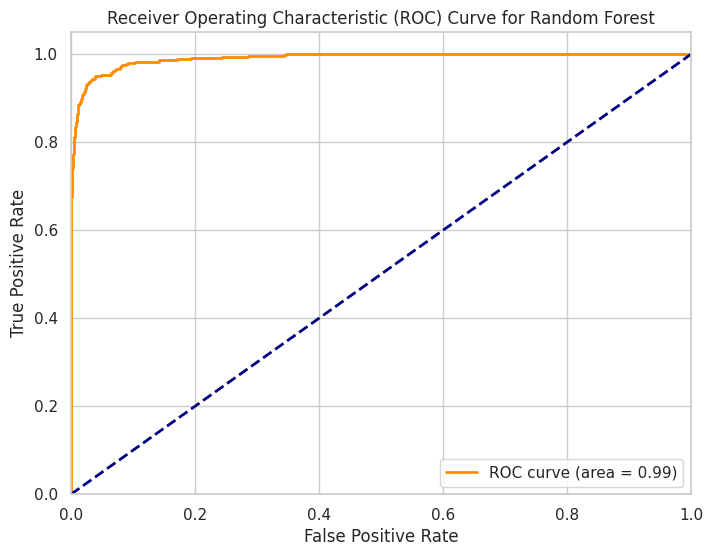

In [32]:
# Get predicted probabilities for the positive class
y_test_pred_prob = loaded_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()

In [42]:
def bootstrap_statistic(y_true, y_pred, statistic_func, B=10_000, alpha=0.05):
    bootstrap_scores = []
    for _ in range(B):
        indices = np.random.choice(len(y_pred), len(y_pred), replace=True)
        resampled_pred = y_pred[indices]
        resampled_true = y_true[indices]
        score, _ = statistic_func(resampled_true, resampled_pred)
        bootstrap_scores.append(score)

    mean_score = np.mean(bootstrap_scores)
    standard_error = np.std(bootstrap_scores, ddof=1)

    # Set the range of values you want to plot (e.g., between 0.70 and 0.74)
    min_value = min(bootstrap_scores)
    max_value = max(bootstrap_scores)

    # Filter data within the specified range
    filtered_data = [x for x in bootstrap_scores if min_value <= x <= max_value]

    # Calculate the 95% confidence interval
    lower_bound = np.percentile(bootstrap_scores, (alpha / 2) * 100)
    upper_bound = np.percentile(bootstrap_scores, (1 - alpha / 2) * 100)

    return mean_score, standard_error, (lower_bound, upper_bound)


In [40]:
def plot_bootstrapped_score(y_trues, y_preds, scoring_funcs, model_names, plot_title="Performance Metrics with Custom Error Bars by Model"):
    score_df = pd.DataFrame(columns=["Model", "Metric", "Mean Score", "SE", "CI_0", "CI_1"])

    for i in range(len(y_trues)):

        data_to_append = []

        for func in scoring_funcs:
            y_true = y_trues[i]
            y_pred = y_preds[i]
            initial_metric, metric_name = func(y_true, y_pred)
            mean_metric, se_metric, ci_95 = bootstrap_statistic(y_true=y_true, y_pred=y_pred, statistic_func=func)
            rounded_mean_metric, rounded_se_metric = round_to_significance(mean_metric, se_metric)
            # Create a dictionary with the data
            data_row = {"Model": model_names[i], "Metric": metric_name, "Mean Score": rounded_mean_metric,
                        "SE": rounded_se_metric, "CI_0": ci_95[0],
                        "CI_1": ci_95[1]}
            data_to_append.append(data_row)

        score_df = pd.concat([score_df, pd.DataFrame(data_to_append)])

    # Set the style and context for the plot
    sns.set()
    sns.set_palette("colorblind")
    if (len(scoring_funcs) <= 2 or len(model_names) <= 3):
        sns.set("poster")
    sns.set_style("whitegrid")
    # color_palette = ["#2aa5a5", "#fc4b00", "#7647fa", "#ffe512", "#ed174f", "#008365", "#c2837a"]
    # color_palette = ["#b2182b", "#ef8a62", "#fddbc7", "#f7f7f7", "#d1e5f0", "#67a9cf", "#2166a"]
    # color_palette = [
    #     "#d73027","#4575b4", "#fc8d59", "#91bfdb",  "#d8b365", "#5ab4ac", "#af8dc3"
    # ]

    # Create the bar plot with custom error bars and hue="Model"
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x="Metric", y="Mean Score", hue="Model", data=score_df, **{'width': 0.3})

    # Customize the plot labels
    ax.set_xlabel("Metric", fontsize=16)
    ax.set_ylabel("Mean Score", fontsize=16)
    ax.set_title(plot_title, fontsize=18)

    # Plot the red line indicating the best performance
    best_performance = score_df['Mean Score'].max()
    plt.axhline(y=best_performance, color='red', linestyle='--')

    # Add the label directly onto the plot
    #plt.text(0.5, best_performance, f'{best_performance:.2f}', color='red', ha='center', va='bottom', fontsize=12)



    plt.legend(title="Model", loc="upper left", bbox_to_anchor=(1, 1), fontsize=15)
    print(score_df)

    # Manually add error bars using the calculated bounds
    for i, bar in enumerate(ax.patches):
        metric_data = score_df.iloc[i]
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        lower_bound = metric_data["CI_0"]
        upper_bound = metric_data["CI_1"]

        plt.plot([x, x], [lower_bound, upper_bound], color="black")
        plt.plot([x - 0.01, x + 0.01], [lower_bound, lower_bound], color="black")
        plt.plot([x - 0.01, x + 0.01], [upper_bound, upper_bound], color="black")

    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.tight_layout()


    plt.show()

In [43]:
y_test=np.array(y_test)
y_pred_test=np.array(y_pred_test)


                 Model     Metric  Mean Score      SE      CI_0      CI_1
0        Random Forest  MCC score       0.800  0.0120  0.773874  0.820677
0  Random Baseline lv0  MCC score       0.001  0.0099 -0.018602  0.020150


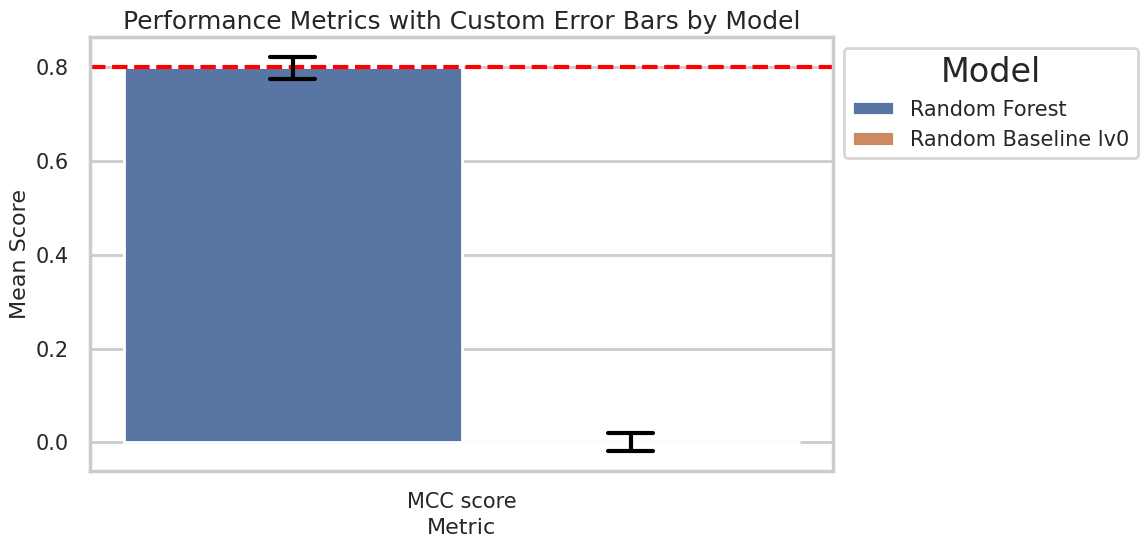

In [51]:
plot_bootstrapped_score(y_trues=[y_test,y_test], y_preds=[y_pred_test, random_baseline_predictions_test], scoring_funcs=[calculate_mcc], model_names=["Random Forest", "Random Baseline lv0"])

                     Model     Metric  Mean Score      SE      CI_0      CI_1
0            Random Forest  MCC score       0.800  0.0120  0.773537  0.821004
0      Random Baseline lv0  MCC score       0.001  0.0099 -0.018581  0.020415
0  Random Baseline lv0_new  MCC score       0.001  0.0097 -0.018410  0.020053


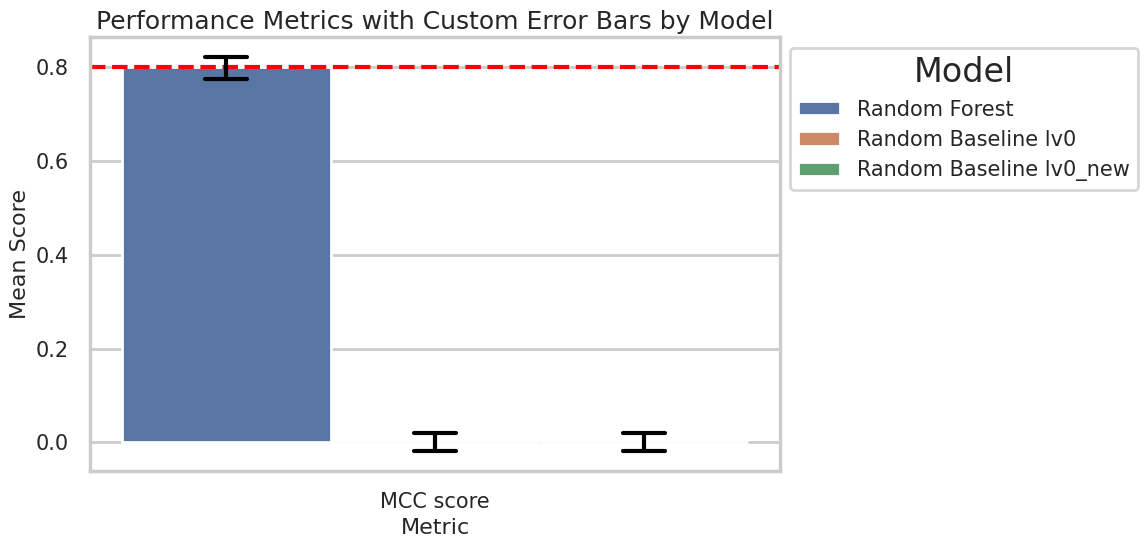

In [54]:
plot_bootstrapped_score(y_trues=[y_test,y_test, y_test], y_preds=[y_pred_test, random_baseline_predictions_test, random_baseline_predictions_test], scoring_funcs=[calculate_mcc], model_names=["Random Forest", "Random Baseline lv0", "Random Baseline lv0_new"])

In [68]:
y_test_df = pd.DataFrame(y_test)
y_test_df.to_csv(r'/home/trucbui/PBLGit/random_forest/y_test.csv', index = False)

In [69]:
y_pred_test_df = pd.DataFrame(y_pred_test)
y_pred_test_df.to_csv(r'/home/trucbui/PBLGit/random_forest/y_pred.csv', index = False)

Check model performance on the 'new' test set

In [ ]:

non_enzymes_test_new_map=readfasta(non_enzymes_test_fasta,False)
non_enzymes_test_new_map = read_esm2(non_enzymes_test_esm2,non_enzymes_test_new_map)



In [23]:
non_enzymes_test_new_df= making_df2(non_enzymes_test_new_map, 392)

In [12]:
enzymes_test_new_fasta = '/home/trucbui/PycharmProjects/PBL2324/venv/Dataset/TestSet/new.fasta'
enzymes_test_new_esm2='/home/trucbui/PycharmProjects/PBL2324/venv/Dataset/TestSet/new_esm2_3b.h5'

In [11]:
def making_df2(seq_map:dict, num_pca_dimension:int)-> pd.DataFrame(): 
    headers=[]
    mass=[]
    labels=[]
    embs=[]
    emb_median_all=[]
    emb_std_all=[]
    emb_magnitude_all=[]
    seqs=[]
    
    
    for header in seq_map:
        headers.append(header)
        entry=seq_map[header]
        labels.append(entry.is_enzyme)
        mass.append(entry.mass)
        embs.append(entry.embeddings)
        emb_median_all.append(entry.emb_median)     
        emb_std_all.append(entry.emb_std)
        emb_magnitude_all.append(entry.emb_magnitude)
        seqs.append(entry.seq)
        
    emb_pca_all=PCA_for_emb((embs),num_pca_dimension).tolist()

    
    return pd.DataFrame(data={'Label':labels ,'Entry':headers, 'Sequence':seqs ,'Mass':mass, 'Emb':embs, 'Emb median': emb_median_all, 
    'Emb std': emb_std_all, 'Emb magnitude': emb_magnitude_all, 'Emb PCA': emb_pca_all})


In [13]:
enzymes_test_new_map=readfasta(enzymes_test_new_fasta,True)
enzymes_test_new_map = read_esm2(enzymes_test_new_esm2,enzymes_test_new_map)
enzymes_test_new_df=making_df2(enzymes_test_new_map, 392)

In [24]:
test_new_df=pd.concat([enzymes_test_new_df,non_enzymes_test_new_df],axis=0).reset_index(drop=True)
test_new_df = test_new_df.sort_values(['Label','Entry'],ascending=[False, True]).reset_index(drop=True)
test_new_df

,Label,Entry,Sequence,Mass,Emb,Emb median,Emb std,Emb magnitude,Emb PCA
0,1,A0A011QK89,MESIEAVVIGAGVVGLACARELARRGFETVILERHGAFGTETSARN...,40497.001,"[-0.0019319912, -0.016816322, 0.028769402, -0....",-0.002018,0.223793,11.323197,"[0.8871048963554711, -0.8051252114936267, -0.3..."
1,1,A0A067XR63,MNAEGGNLHREFEITWGDGRARIHNNGGLLTLSLDRASGSGFRSKN...,30796.835,"[-0.05900694, 0.019138305, 0.005838026, -0.002...",-0.002315,0.242572,12.273351,"[-0.9221102992133166, -0.4889752176834336, 0.3..."
2,1,A0A067XRK9,MASSLTLPMAMAFTLLALSFASAMGGSMNSSRFDELFQPSWAFDHF...,33724.077,"[-0.055320676, 0.0015649835, 0.06592601, -0.04...",-0.002057,0.249882,12.643257,"[-1.263780984979214, -0.49222965771632227, 0.4..."
3,1,A0A067YMX8,MAASPYSIFAVQLLLLASWMLSSSSSNFNQDFNIAWGGGRARILNN...,32487.228,"[-0.05380216, 0.0067072976, 0.035263997, -0.03...",-0.002104,0.244987,12.395542,"[-0.9622962401564922, -0.42492008659882313, 0...."
4,1,A0A075HNX4,MAQGAQRKNFGHNQILRPSAAYTPVDEQEVLQILDRHRGQRIRAVG...,54326.966,"[0.053292472, -0.03966276, -0.0039877286, -0.0...",-0.001942,0.235786,11.930012,"[-0.2702486429773216, -0.7499056606668549, 0.1..."
...,...,...,...,...,...,...,...,...,...
10263,0,W2PDG1,MKSFLIAIVIAVLLPVSAADFCAQWRLSKAGKYIIYNNLWNQNTAT...,25510.828,"[0.033741392, 0.053279333, -0.056721542, -0.05...",-0.002122,0.243228,12.306490,"[1.5100021421980934, -0.44248949160991846, -0...."
10264,0,W4VSH9,MNFELIYVSSLLLGICLANQADVVPSDCNLPADAGMCYAYFPMFFY...,19243.713,"[0.020676099, -0.003858359, -0.087140284, -0.0...",-0.003511,0.243193,12.304819,"[0.5215536276939348, 0.07031820191128332, -0.2..."
10265,0,W5U5X5,MKALYLLGLLAFLYSCSSENVYDLQPESSEEENPGTFLEAIQEQSR...,20317.651,"[0.07092074, -0.02695332, 0.029215096, -0.0391...",-0.003557,0.271204,13.722124,"[-0.7907849769804962, -0.5922241717814768, 0.0..."
10266,0,W5XKT8,MALLALASAVPSALLALAVFRVPAWACLLCFTTYSERLRICQMFVG...,36291.238,"[0.04543773, -0.08296901, -0.016205797, -0.039...",-0.003594,0.241647,12.226573,"[2.341523138194804, 0.06074803250567936, 0.928..."


In [25]:
for i in range(392):
    test_new_df[f'PCA {i + 1}'] = test_new_df['Emb PCA'].apply(lambda x: x[i])
test_new_df


/tmp/ipykernel_152033/1495871770.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_new_df[f'PCA {i + 1}'] = test_new_df['Emb PCA'].apply(lambda x: x[i])
/tmp/ipykernel_152033/1495871770.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_new_df[f'PCA {i + 1}'] = test_new_df['Emb PCA'].apply(lambda x: x[i])
/tmp/ipykernel_152033/1495871770.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

,Label,Entry,Sequence,Mass,Emb,Emb median,Emb std,Emb magnitude,Emb PCA,PCA 1,...,PCA 383,PCA 384,PCA 385,PCA 386,PCA 387,PCA 388,PCA 389,PCA 390,PCA 391,PCA 392
0,1,A0A011QK89,MESIEAVVIGAGVVGLACARELARRGFETVILERHGAFGTETSARN...,40497.001,"[-0.0019319912, -0.016816322, 0.028769402, -0....",-0.002018,0.223793,11.323197,"[0.8871048963554711, -0.8051252114936267, -0.3...",0.887105,...,0.000057,4.194890e-05,9.565462e-07,5.507171e-16,2.034914e-18,1.686363e-18,1.241681e-19,7.516849e-20,6.248737e-20,1.431482e-20
1,1,A0A067XR63,MNAEGGNLHREFEITWGDGRARIHNNGGLLTLSLDRASGSGFRSKN...,30796.835,"[-0.05900694, 0.019138305, 0.005838026, -0.002...",-0.002315,0.242572,12.273351,"[-0.9221102992133166, -0.4889752176834336, 0.3...",-0.922110,...,0.000006,-2.616770e-05,3.402746e-06,5.507171e-16,2.034914e-18,1.686363e-18,1.241681e-19,7.516849e-20,6.248737e-20,1.431482e-20
2,1,A0A067XRK9,MASSLTLPMAMAFTLLALSFASAMGGSMNSSRFDELFQPSWAFDHF...,33724.077,"[-0.055320676, 0.0015649835, 0.06592601, -0.04...",-0.002057,0.249882,12.643257,"[-1.263780984979214, -0.49222965771632227, 0.4...",-1.263781,...,-0.000043,1.025712e-05,-7.796924e-06,5.507171e-16,2.034914e-18,1.686363e-18,1.241681e-19,7.516849e-20,6.248737e-20,1.431482e-20
3,1,A0A067YMX8,MAASPYSIFAVQLLLLASWMLSSSSSNFNQDFNIAWGGGRARILNN...,32487.228,"[-0.05380216, 0.0067072976, 0.035263997, -0.03...",-0.002104,0.244987,12.395542,"[-0.9622962401564922, -0.42492008659882313, 0....",-0.962296,...,-0.000047,-1.334397e-05,-1.238287e-06,5.507171e-16,2.034914e-18,1.686363e-18,1.241681e-19,7.516849e-20,6.248737e-20,1.431482e-20
4,1,A0A075HNX4,MAQGAQRKNFGHNQILRPSAAYTPVDEQEVLQILDRHRGQRIRAVG...,54326.966,"[0.053292472, -0.03966276, -0.0039877286, -0.0...",-0.001942,0.235786,11.930012,"[-0.2702486429773216, -0.7499056606668549, 0.1...",-0.270249,...,0.000003,2.569750e-07,3.082961e-07,5.507171e-16,2.034914e-18,1.686363e-18,1.241681e-19,7.516849e-20,6.248737e-20,1.431482e-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10263,0,W2PDG1,MKSFLIAIVIAVLLPVSAADFCAQWRLSKAGKYIIYNNLWNQNTAT...,25510.828,"[0.033741392, 0.053279333, -0.056721542, -0.05...",-0.002122,0.243228,12.306490,"[1.5100021421980934, -0.44248949160991846, -0....",1.510002,...,-0.004787,2.673275e-02,-4.064006e-02,3.193663e-02,4.331230e-02,-7.219616e-03,2.971069e-04,-2.141987e-02,3.678912e-02,-5.510048e-02
10264,0,W4VSH9,MNFELIYVSSLLLGICLANQADVVPSDCNLPADAGMCYAYFPMFFY...,19243.713,"[0.020676099, -0.003858359, -0.087140284, -0.0...",-0.003511,0.243193,12.304819,"[0.5215536276939348, 0.07031820191128332, -0.2...",0.521554,...,-0.014643,2.239905e-02,2.100895e-02,-3.091993e-02,7.008921e-02,1.706129e-02,-1.314091e-03,-6.163686e-02,4.300923e-02,6.585840e-02
10265,0,W5U5X5,MKALYLLGLLAFLYSCSSENVYDLQPESSEEENPGTFLEAIQEQSR...,20317.651,"[0.07092074, -0.02695332, 0.029215096, -0.0391...",-0.003557,0.271204,13.722124,"[-0.7907849769804962, -0.5922241717814768, 0.0...",-0.790785,...,0.061699,-5.512423e-02,-9.213948e-03,-2.501807e-02,-3.823218e-02,1.857107e-02,4.945156e-02,-5.612804e-02,4.807085e-02,-2.728743e-02
10266,0,W5XKT8,MALLALASAVPSALLALAVFRVPAWACLLCFTTYSERLRICQMFVG...,36291.238,"[0.04543773, -0.08296901, -0.016205797, -0.039...",-0.003594,0.241647,12.226573,"[2.341523138194804, 0.06074803250567936, 0.928...",2.341523,...,-0.029061,-1.090140e-02,9.349081e-03,4.734725e-03,-6.734777e-03,4.925721e-02,-1.192759e-02,-4.267642e-02,1.347895e-02,1.710016e-02


In [27]:
test_new_df.to_csv(r'/home/trucbui/PBLGit/random_forest/test_new_df.csv', index = False)

In [2]:
test_new_df = pd.read_csv(r'/home/trucbui/PBLGit/random_forest/test_new_df.csv')

In [3]:

test_new_df_reduced_pca=test_new_df[['Label', 'Entry', 'Sequence', 'Mass', 'Emb median', 'Emb std', 'Emb magnitude', 'PCA 1', 'PCA 2',
       'PCA 3', 'PCA 4', 'PCA 5', 'PCA 6', 'PCA 7', 'PCA 8', 'PCA 9', 'PCA 10',
       'PCA 11', 'PCA 12', 'PCA 13', 'PCA 14', 'PCA 15', 'PCA 16', 'PCA 17',
       'PCA 18', 'PCA 19', 'PCA 20', 'PCA 21', 'PCA 22', 'PCA 23', 'PCA 24',
       'PCA 25', 'PCA 26', 'PCA 27', 'PCA 28', 'PCA 30', 'PCA 32', 'PCA 33',
       'PCA 34', 'PCA 37', 'PCA 38', 'PCA 43', 'PCA 45', 'PCA 47']]
test_new_df_reduced_pca

,Label,Entry,Sequence,Mass,Emb median,Emb std,Emb magnitude,PCA 1,PCA 2,PCA 3,...,PCA 28,PCA 30,PCA 32,PCA 33,PCA 34,PCA 37,PCA 38,PCA 43,PCA 45,PCA 47
0,1,A0A011QK89,MESIEAVVIGAGVVGLACARELARRGFETVILERHGAFGTETSARN...,40497.001,-0.002018,0.223793,11.323197,0.887105,-0.805125,-0.325224,...,-0.371667,-0.074375,0.129761,-0.513339,-0.191537,-0.051191,-0.107923,0.222198,-0.003451,-0.083842
1,1,A0A067XR63,MNAEGGNLHREFEITWGDGRARIHNNGGLLTLSLDRASGSGFRSKN...,30796.835,-0.002315,0.242572,12.273351,-0.922110,-0.488975,0.367726,...,-0.133213,-0.060824,-0.020352,0.086416,-0.069407,0.104835,0.054716,-0.015923,0.017494,-0.233045
2,1,A0A067XRK9,MASSLTLPMAMAFTLLALSFASAMGGSMNSSRFDELFQPSWAFDHF...,33724.077,-0.002057,0.249882,12.643257,-1.263781,-0.492230,0.400709,...,-0.013508,-0.071249,0.014658,0.015524,-0.045239,0.109444,0.176987,0.069075,0.031715,-0.187905
3,1,A0A067YMX8,MAASPYSIFAVQLLLLASWMLSSSSSNFNQDFNIAWGGGRARILNN...,32487.228,-0.002104,0.244987,12.395542,-0.962296,-0.424920,0.352358,...,-0.044160,-0.123610,0.031208,0.022151,-0.038155,0.108208,0.087113,0.085756,0.018733,-0.154861
4,1,A0A075HNX4,MAQGAQRKNFGHNQILRPSAAYTPVDEQEVLQILDRHRGQRIRAVG...,54326.966,-0.001942,0.235786,11.930012,-0.270249,-0.749906,0.117540,...,-0.269889,0.435125,0.235064,-0.212149,-0.086280,-0.164229,0.017185,-0.077381,-0.202827,0.036157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10263,0,W2PDG1,MKSFLIAIVIAVLLPVSAADFCAQWRLSKAGKYIIYNNLWNQNTAT...,25510.828,-0.002122,0.243228,12.306490,1.510002,-0.442489,-0.250064,...,-0.295735,-0.070113,0.228629,0.156010,0.116330,-0.106937,-0.351612,-0.079452,-0.273796,-0.125412
10264,0,W4VSH9,MNFELIYVSSLLLGICLANQADVVPSDCNLPADAGMCYAYFPMFFY...,19243.713,-0.003511,0.243193,12.304819,0.521554,0.070318,-0.215755,...,0.245629,0.132582,-0.012851,0.272221,-0.120324,-0.167499,0.156868,-0.179433,-0.032822,0.056176
10265,0,W5U5X5,MKALYLLGLLAFLYSCSSENVYDLQPESSEEENPGTFLEAIQEQSR...,20317.651,-0.003557,0.271204,13.722124,-0.790785,-0.592224,0.057077,...,0.144901,0.162766,0.182106,0.008402,0.106958,0.025462,0.018515,-0.030414,0.001166,0.027862
10266,0,W5XKT8,MALLALASAVPSALLALAVFRVPAWACLLCFTTYSERLRICQMFVG...,36291.238,-0.003594,0.241647,12.226573,2.341523,0.060748,0.928006,...,-0.111066,0.150977,0.154511,-0.054656,-0.204487,-0.164063,-0.000080,-0.006804,-0.073931,-0.065840


In [24]:
y_test_new=test_new_df_reduced_pca['Label']
X_test_new=test_new_df_reduced_pca[['Mass', 'Emb median', 'Emb std', 'Emb magnitude', 'PCA 1', 'PCA 2',
       'PCA 3', 'PCA 4', 'PCA 5', 'PCA 6', 'PCA 7', 'PCA 8', 'PCA 9', 'PCA 10',
       'PCA 11', 'PCA 12', 'PCA 13', 'PCA 14', 'PCA 15', 'PCA 16', 'PCA 17',
       'PCA 18', 'PCA 19', 'PCA 20', 'PCA 21', 'PCA 22', 'PCA 23', 'PCA 24',
       'PCA 25', 'PCA 26', 'PCA 27', 'PCA 28', 'PCA 30', 'PCA 32', 'PCA 33',
       'PCA 34', 'PCA 37', 'PCA 38', 'PCA 43', 'PCA 45', 'PCA 47']]

In [31]:

y_pred_test_new=loaded_model.predict(X_test_new)


In [35]:
print(len(y_pred_test_new))
y_pred_test_new

10268


array([1, 1, 1, ..., 0, 0, 0])

In [36]:
print(len(y_test_new))
y_test_new

10268


0        1
1        1
2        1
3        1
4        1
        ..
10263    0
10264    0
10265    0
10266    0
10267    0
Name: Label, Length: 10268, dtype: int64

In [37]:

loaded_model_accuracy_new = loaded_model.score(X_test_new, y_test_new)
print("Loaded Model Accuracy on the 'new' testset:" , loaded_model_accuracy_new)

f1_test_new = f1_score(y_test_new, y_pred_test_new, zero_division="warn")
print("F1 score on the 'new' testset:", f1_test_new)

weighted_f1_test_new,_ = calculate_weighted_f1(y_test_new, y_pred_test_new)
print("Weighted F1 score on the 'new' testset:", weighted_f1_test_new)

mcc_test_new=matthews_corrcoef(y_test_new, y_pred_test_new)
print("MCC score on the 'new' testset:", mcc_test_new)

precision_test_new = precision_score(y_test_new, y_pred_test_new)
print(f"Precision on the 'new' testset = {precision_test_new}")

recall_test_new = recall_score(y_test_new, y_pred_test_new)
print(f"Recall on the 'new' testset = {recall_test_new}")

Loaded Model Accuracy on the 'new' testset: 0.9759446825087651
F1 score on the 'new' testset: 0.740273396424816
Weighted F1 score on the 'new' testset: 0.9779542359821386
MCC score on the 'new' testset: 0.7406954159990619
Precision on the 'new' testset = 0.629695885509839
Recall on the 'new' testset = 0.8979591836734694


In [38]:
y_test_new.to_csv(r'/home/trucbui/PBLGit/random_forest/y_test_new.csv', index = False)

In [18]:
X_test_new.to_csv(r'/home/trucbui/PBLGit/random_forest/X_test_new.csv', index = False)

In [41]:
y_pred_new_df=pd.DataFrame({'Label': y_pred_test_new})
y_pred_new_df.to_csv(r'/home/trucbui/PBLGit/random_forest/y_pred_new.csv', index = False)

In [45]:
new_df = pd.DataFrame({'Label': y_test_new, 'Prediction': y_pred_test_new})
new_df.to_csv(r'/home/trucbui/PBLGit/random_forest/new_df.csv', index = False)

Loaded Model Accuracy: 0.9754161086665392

F1 score: 0.8042650418888042

MCC score: 0.7978572753152363

Precision = 0.7183673469387755

Recall = 0.9134948096885813

In [36]:
n_samples_random_baseline_test_new = len(y_test_new)
random_baseline_predictions_test_new = np.random.choice(np.array(y_train_dup).flatten(), n_samples_random_baseline_test_new)

baseline_accuracy_test_new = accuracy_score(y_test_new, random_baseline_predictions_test_new)
baseline_mcc_test_new=matthews_corrcoef(y_test_new, random_baseline_predictions_test_new)
baseline_f1_test_new=f1_score(y_test_new, random_baseline_predictions_test_new, zero_division="warn")
baseline_weighted_f1_test_new,_=calculate_weighted_f1(y_test_new, random_baseline_predictions_test_new)
baseline_precsion_test_new=precision_score(y_test_new, random_baseline_predictions_test_new)
baseline_recall_test_new=recall_score(y_test_new, random_baseline_predictions_test_new)

print("Baseline Accuracy (Random Guessing) on the 'new' testset:", baseline_accuracy_test_new)
print("Baseline F1 (Random Guessing)on the 'new' testset:", baseline_f1_test_new)
print("Baseline Weighted F1 (Random Guessing)on the 'new' testset:", baseline_weighted_f1_test_new)
print("Baseline MCC (Random Guessing) on the 'new' testset:", baseline_mcc_test_new)
print("Baseline Precision (Random Guessing)on the 'new' testset:", baseline_precsion_test_new)
print("Baseline Recall (Random Guessing) on the 'new' testset:", baseline_recall_test_new)

Baseline Accuracy (Random Guessing) on the 'new' testset: 0.5060381768601481
Baseline F1 (Random Guessing)on the 'new' testset: 0.0737764791818846
Baseline Weighted F1 (Random Guessing)on the 'new' testset: 0.6407109448220613
Baseline MCC (Random Guessing) on the 'new' testset: 0.008039517284506078
Baseline Precision (Random Guessing)on the 'new' testset: 0.03973249409913454
Baseline Recall (Random Guessing) on the 'new' testset: 0.5153061224489796


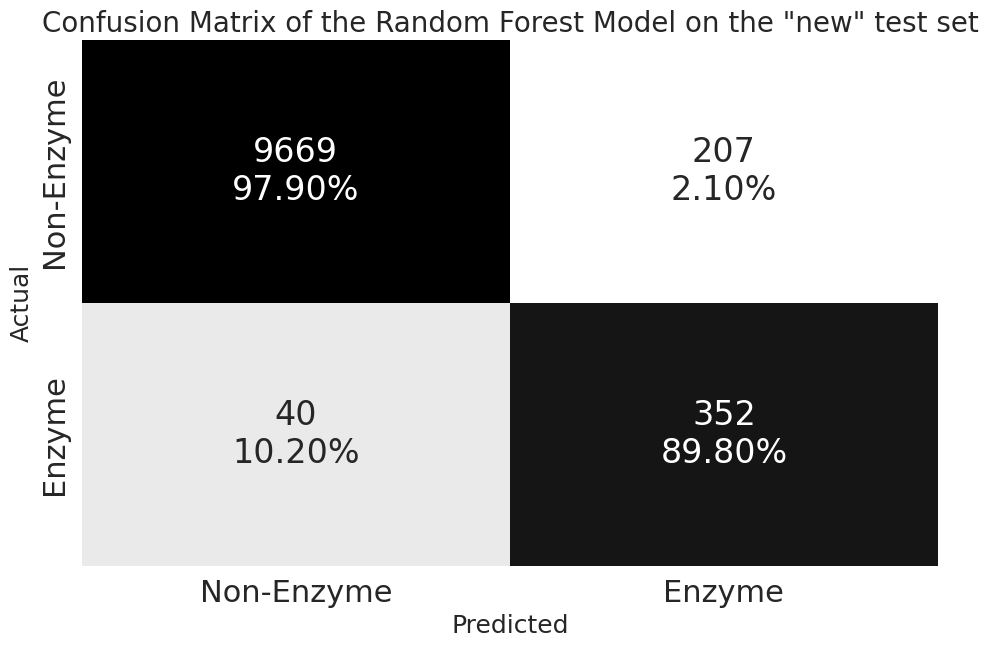

In [38]:
cf_matrix = confusion_matrix(y_test_new, y_pred_test_new)
cf_matrix_normal = confusion_matrix(y_test_new, y_pred_test_new, normalize='true')
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_normal.flatten()]
labels = [f"{v2}\n{v3}" for v2, v3 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(cf_matrix_normal, annot=labels, fmt="", cmap="binary", cbar=False, xticklabels=['Non-Enzyme', 'Enzyme'], yticklabels=['Non-Enzyme', 'Enzyme'])

sns.set(font_scale=2)
plt.xlabel("Predicted", fontsize=18)
plt.ylabel("Actual", fontsize=18)

plt.title('Confusion Matrix of the Random Forest Model on the "new" test set', fontsize=20)
plt.tight_layout()
plt.show()

/tmp/ipykernel_152033/1702207576.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(categories, rotation=45, horizontalalignment='right')


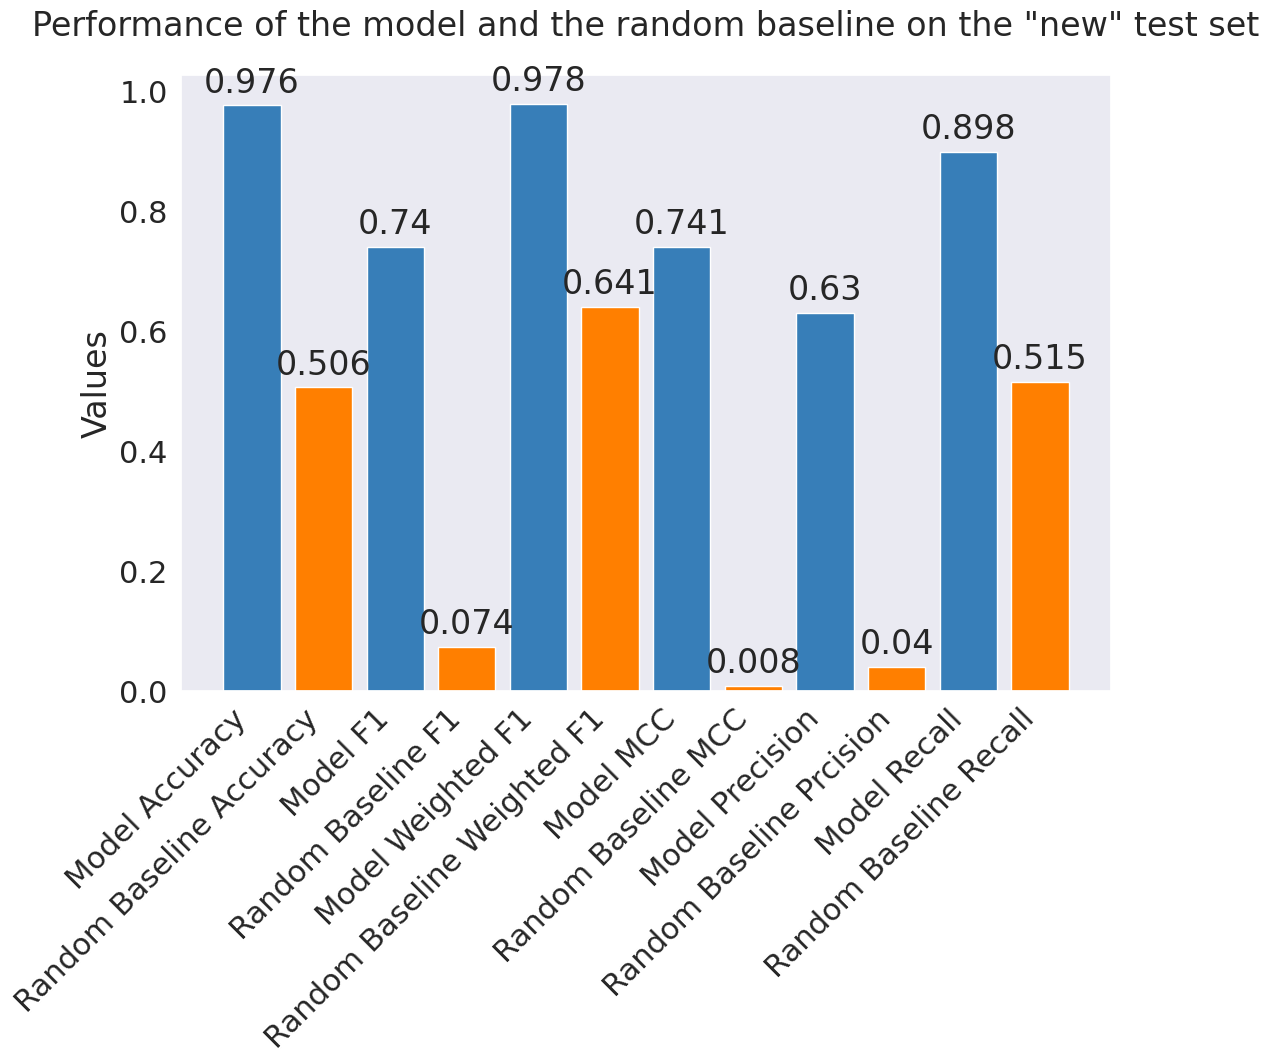

In [39]:
# Plot the results of the model and the random baseline
# Showing accuracy, f1, mcc, precision and recall
categories = ['Model Accuracy','Random Baseline Accuracy' ,'Model F1','Random Baseline F1','Model Weighted F1','Random Baseline Weighted F1' ,'Model MCC','Random Baseline MCC' ,'Model Precision','Random Baseline Prcision' ,'Model Recall', 'Random Baseline Recall']
values = [loaded_model_accuracy_new, baseline_accuracy_test_new, f1_test_new, baseline_f1_test_new,weighted_f1_test_new,baseline_weighted_f1_test_new ,mcc_test_new, baseline_mcc_test_new, precision_test_new, baseline_precsion_test_new, recall_test_new, baseline_recall_test_new]
plt.figure(figsize=(12, 8))

# Create a bar plot
plt.bar(categories, values,color=['#377eb8', '#ff7f00','#377eb8', '#ff7f00','#377eb8', '#ff7f00','#377eb8', '#ff7f00','#377eb8', '#ff7f00'])

# Rotate the category labels for better readability
plt.gca().set_xticklabels(categories, rotation=45, horizontalalignment='right')

# Add values on top of each bar
for i, v in enumerate(values):
    plt.text(i, v + 0.01, str(round(v, 3)), ha='center', va='bottom')

plt.ylabel('Values')
plt.title('Performance of the model and the random baseline on the "new" test set',y=1.05)

plt.grid(False)
plt.show()


                 Model             Metric  Mean Score      SE      CI_0  \
0        Random Forest          MCC score       0.740  0.0150  0.710690   
1        Random Forest  Weighted F1-Score       0.978  0.0013  0.975365   
0  Random Baseline lv0          MCC score       0.008  0.0098 -0.010969   
1  Random Baseline lv0  Weighted F1-Score       0.641  0.0045  0.631808   

       CI_1  
0  0.769411  
1  0.980484  
0  0.027186  
1  0.649470  


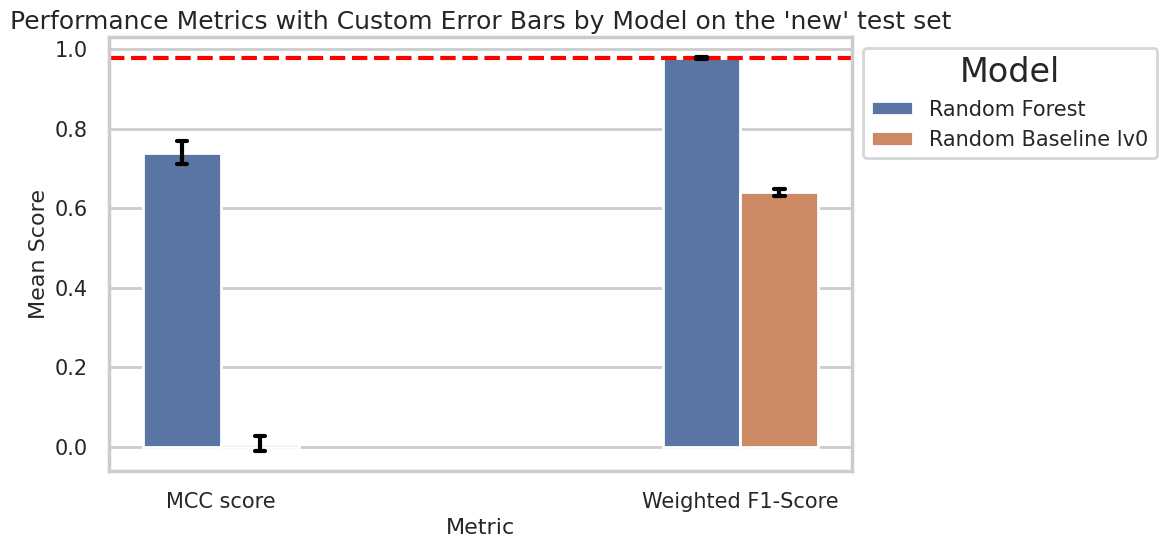

In [45]:
plot_bootstrapped_score(y_trues=[y_test_new,y_test_new], y_preds=[y_pred_test_new, random_baseline_predictions_test_new], scoring_funcs=[calculate_mcc, calculate_weighted_f1], model_names=["Random Forest", "Random Baseline lv0"], plot_title="Performance Metrics with Custom Error Bars by Model on the 'new' test set")

Check model performance on the "price" test set

In [207]:
enzymes_test_price_fasta = '/home/trucbui/PycharmProjects/PBL2324/venv/Dataset/TestSet/price.fasta'
enzymes_test_price_esm2='/home/trucbui/PycharmProjects/PBL2324/venv/Dataset/TestSet/price_esm2_3b.h5'

In [208]:
enzymes_test_price_map=readfasta(enzymes_test_price_fasta,True)
enzymes_test_price_map = read_esm2(enzymes_test_price_esm2,enzymes_test_price_map)
enzymes_test_price_df=making_df2(enzymes_test_price_map, 149)

In [212]:
test_price_df=pd.concat([enzymes_test_price_df,non_enzymes_test_new_df],axis=0).reset_index(drop=True)
test_price_df = test_price_df.sort_values(['Label','Entry'],ascending=[False, True]).reset_index(drop=True)
test_price_df

,Label,Entry,Sequence,Mass,Emb,Emb median,Emb std,Emb magnitude,Emb PCA
0,1,NP_384124,MPAPSSILLSPDDNVVVATAAIAPGDRLAGGVSAVARIEPGHKAAI...,52004.501,"[-0.046285976, -0.031000908, 0.000107974585, -...",-0.002627,0.237042,11.993581,"[-0.8423267858404664, -0.023506111262448653, -..."
1,1,NP_384306,MTFYLIGIDGGGTSCRAAVAALDGRILGRGKAGAANILTDPETALQ...,30254.582,"[-0.03660759, -0.026987234, -0.00424658, -0.00...",-0.001274,0.227525,11.512021,"[-0.7560181145664544, -0.10099228953020636, -0..."
2,1,NP_384521,MSSARKIIIDTDPGQDDAAAIMLALGSPEEIEVLGITAVAGNVPLT...,33945.553,"[0.010542, -0.038471278, -0.007785792, -0.0240...",-0.002550,0.222882,11.277085,"[0.08664962459137217, 0.7430187672635247, -0.2..."
3,1,NP_384733,MTLMISTSVLDAENASRRDALTRDYESLGDRLARRGIDIDAVKAKV...,46660.353,"[-0.009100076, -0.061023943, -0.010560309, -0....",-0.004196,0.245625,12.427842,"[-1.2370000117905704, -0.14385461641757322, 0...."
4,1,NP_384734,MLDKHQGARLANLWDDGKAAGMTEPEKLLYRSNLLGSDKRITNYGG...,75584.397,"[0.027971158, -0.025486505, -0.043167353, -0.0...",-0.002862,0.222678,11.266770,"[-0.20730219758578894, -0.2736748573163259, 0...."
...,...,...,...,...,...,...,...,...,...
10020,0,W2PDG1,MKSFLIAIVIAVLLPVSAADFCAQWRLSKAGKYIIYNNLWNQNTAT...,25510.828,"[0.033741392, 0.053279333, -0.056721542, -0.05...",-0.002122,0.243228,12.306490,"[1.5100018978118896, -0.4424901604652405, -0.2..."
10021,0,W4VSH9,MNFELIYVSSLLLGICLANQADVVPSDCNLPADAGMCYAYFPMFFY...,19243.713,"[0.020676099, -0.003858359, -0.087140284, -0.0...",-0.003511,0.243193,12.304819,"[0.5215535163879395, 0.0703180655837059, -0.21..."
10022,0,W5U5X5,MKALYLLGLLAFLYSCSSENVYDLQPESSEEENPGTFLEAIQEQSR...,20317.651,"[0.07092074, -0.02695332, 0.029215096, -0.0391...",-0.003557,0.271204,13.722124,"[-0.7907861471176147, -0.5922241806983948, 0.0..."
10023,0,W5XKT8,MALLALASAVPSALLALAVFRVPAWACLLCFTTYSERLRICQMFVG...,36291.238,"[0.04543773, -0.08296901, -0.016205797, -0.039...",-0.003594,0.241647,12.226573,"[2.3415234088897705, 0.06074751541018486, 0.92..."


In [214]:
for i in range(149):
    test_price_df[f'PCA {i + 1}'] = test_price_df['Emb PCA'].apply(lambda x: x[i])


In [215]:

test_price_df_reduced_pca=test_price_df[['Label', 'Entry', 'Sequence', 'Mass', 'Emb median', 'Emb std', 'Emb magnitude', 'PCA 1', 'PCA 2',
       'PCA 3', 'PCA 4', 'PCA 5', 'PCA 6', 'PCA 7', 'PCA 8', 'PCA 9', 'PCA 10',
       'PCA 11', 'PCA 12', 'PCA 13', 'PCA 14', 'PCA 15', 'PCA 16', 'PCA 17',
       'PCA 18', 'PCA 19', 'PCA 20', 'PCA 21', 'PCA 22', 'PCA 23', 'PCA 24',
       'PCA 25', 'PCA 26', 'PCA 27', 'PCA 28', 'PCA 30', 'PCA 32', 'PCA 33',
       'PCA 34', 'PCA 37', 'PCA 38', 'PCA 43', 'PCA 45', 'PCA 47']]

y_test_price=test_price_df_reduced_pca['Label']
X_test_price=test_price_df_reduced_pca[['Mass', 'Emb median', 'Emb std', 'Emb magnitude', 'PCA 1', 'PCA 2',
       'PCA 3', 'PCA 4', 'PCA 5', 'PCA 6', 'PCA 7', 'PCA 8', 'PCA 9', 'PCA 10',
       'PCA 11', 'PCA 12', 'PCA 13', 'PCA 14', 'PCA 15', 'PCA 16', 'PCA 17',
       'PCA 18', 'PCA 19', 'PCA 20', 'PCA 21', 'PCA 22', 'PCA 23', 'PCA 24',
       'PCA 25', 'PCA 26', 'PCA 27', 'PCA 28', 'PCA 30', 'PCA 32', 'PCA 33',
       'PCA 34', 'PCA 37', 'PCA 38', 'PCA 43', 'PCA 45', 'PCA 47']]

In [229]:
y_pred_test_price=loaded_model.predict(X_test_price)
loaded_model_accuracy_price = loaded_model.score(X_test_price, y_test_price)

print("Loaded Model Accuracy on the 'price' testset:" , loaded_model_accuracy_price)
f1_test_price = f1_score(y_test_price, y_pred_test_price, zero_division="warn")
print("F1 score on the 'price' testset:", f1_test_price)
weighted_f1_test_price,_ = calculate_weighted_f1(y_test_price, y_pred_test_price)
print("Weighted F1 score on the 'price' testset:", weighted_f1_test_price)
mcc_test_price=matthews_corrcoef(y_test_price, y_pred_test_price)
print("MCC score on the 'price' testset:", mcc_test_price)
precision_test_price = precision_score(y_test_price, y_pred_test_price)
print(f"Precision on the 'price' testset = {precision_test_price}")
recall_test_price = recall_score(y_test_price, y_pred_test_price)
print(f"Recall on the 'price' testset = {recall_test_price}")

Loaded Model Accuracy on the 'price' testset: 0.9792518703241895
F1 score on the 'price' testset: 0.5873015873015872
Weighted F1 score on the 'price' testset: 0.9833827287250212
MCC score on the 'price' testset: 0.6366039965089794
Precision on the 'price' testset = 0.4169014084507042
Recall on the 'price' testset = 0.9932885906040269


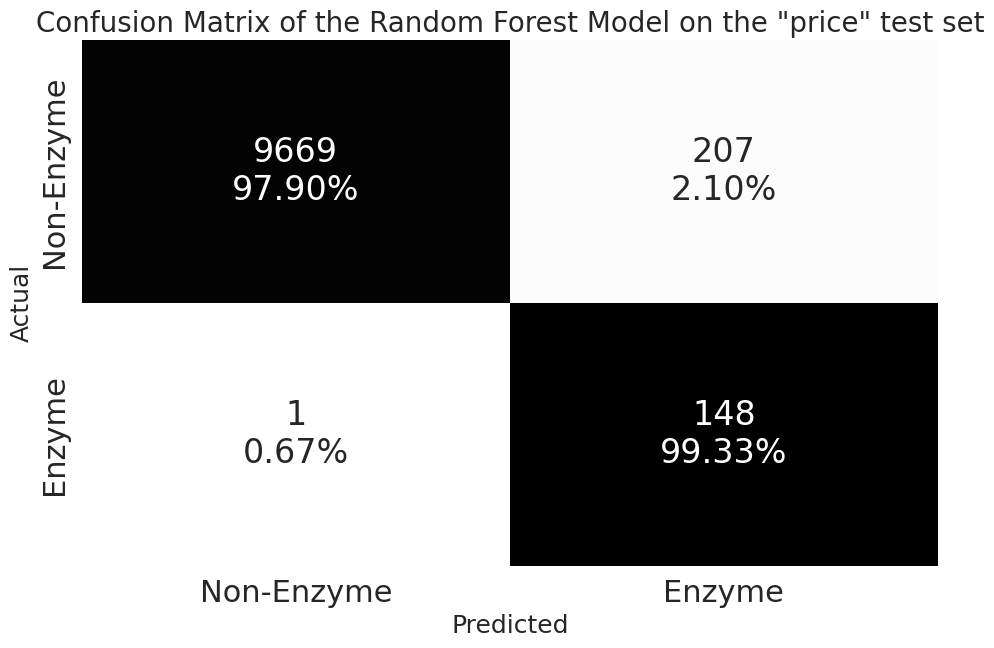

In [218]:
cf_matrix = confusion_matrix(y_test_price, y_pred_test_price)
cf_matrix_normal = confusion_matrix(y_test_price, y_pred_test_price, normalize='true')
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_normal.flatten()]
labels = [f"{v2}\n{v3}" for v2, v3 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(cf_matrix_normal, annot=labels, fmt="", cmap="binary", cbar=False, xticklabels=['Non-Enzyme', 'Enzyme'], yticklabels=['Non-Enzyme', 'Enzyme'])

sns.set(font_scale=2)
plt.xlabel("Predicted", fontsize=18)
plt.ylabel("Actual", fontsize=18)

plt.title('Confusion Matrix of the Random Forest Model on the "price" test set', fontsize=20)
plt.tight_layout()
plt.show()

In [232]:
n_samples_random_baseline_test_price = len(y_test_price)
random_baseline_predictions_test_price = np.random.choice(np.array(y_train_dup).flatten(), n_samples_random_baseline_test_price)

baseline_accuracy_test_price = accuracy_score(y_test_price, random_baseline_predictions_test_price)
baseline_mcc_test_price=matthews_corrcoef(y_test_price, random_baseline_predictions_test_price)
baseline_f1_test_price=f1_score(y_test_price, random_baseline_predictions_test_price, zero_division="warn")
baseline_weighted_f1_test_price,_=calculate_weighted_f1(y_test_price, random_baseline_predictions_test_price)
baseline_precsion_test_price=precision_score(y_test_price, random_baseline_predictions_test_price)
baseline_recall_test_price=recall_score(y_test_price, random_baseline_predictions_test_price)

print("Baseline Accuracy (Random Guessing) on the 'price' testset:", baseline_accuracy_test_price)
print("Baseline F1 (Random Guessing)on the 'price' testset:", baseline_f1_test_price)
print("Baseline Weighted F1 (Random Guessing)on the 'price' testset:", baseline_weighted_f1_test_price)
print("Baseline MCC (Random Guessing) on the 'price' testset:", baseline_mcc_test_price)
print("Baseline Precision (Random Guessing)on the 'price' testset:", baseline_precsion_test_price)
print("Baseline Recall (Random Guessing) on the 'price' testset:", baseline_recall_test_price)

Baseline Accuracy (Random Guessing) on the 'price' testset: 0.5106234413965087
Baseline F1 (Random Guessing)on the 'price' testset: 0.028129952456418382
Baseline Weighted F1 (Random Guessing)on the 'price' testset: 0.663392676996124
Baseline MCC (Random Guessing) on the 'price' testset: -0.0029900029619369076
Baseline Precision (Random Guessing)on the 'price' testset: 0.014492753623188406
Baseline Recall (Random Guessing) on the 'price' testset: 0.47651006711409394


/tmp/ipykernel_147158/3464869565.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(categories, rotation=45, horizontalalignment='right')


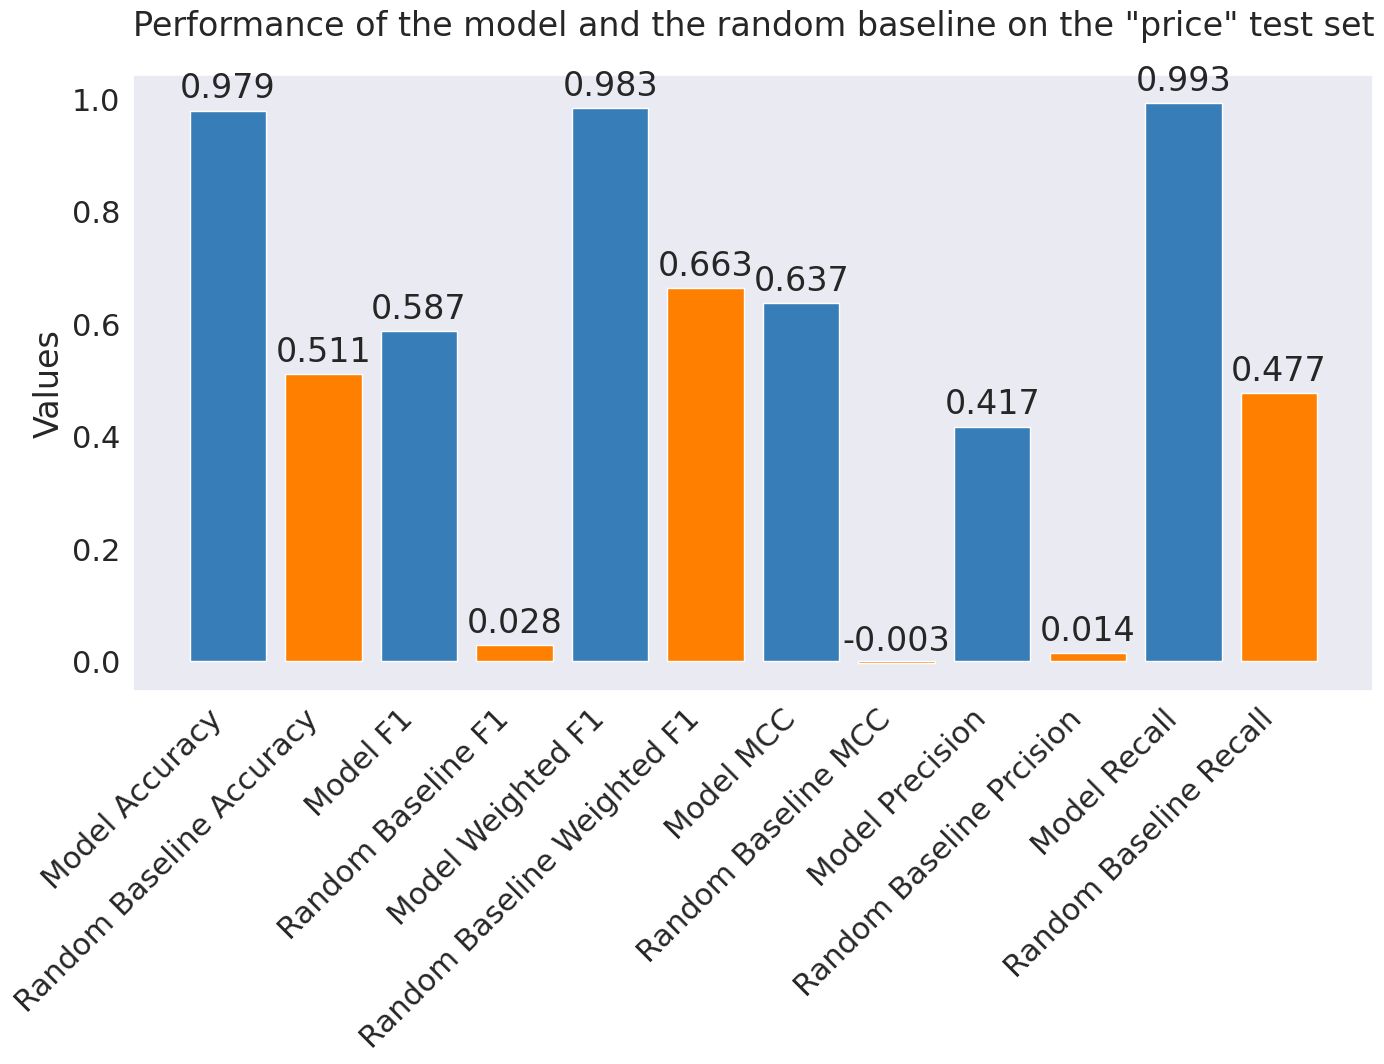

In [244]:
# Plot the results of the model and the random baseline
# Showing accuracy, f1, mcc, precision and recall
categories = ['Model Accuracy','Random Baseline Accuracy' ,'Model F1','Random Baseline F1','Model Weighted F1','Random Baseline Weighted F1' ,'Model MCC','Random Baseline MCC' ,'Model Precision','Random Baseline Prcision' ,'Model Recall', 'Random Baseline Recall']
values = [loaded_model_accuracy_price, baseline_accuracy_test_price, f1_test_price, baseline_f1_test_price, weighted_f1_test_price, baseline_weighted_f1_test_price ,mcc_test_price, baseline_mcc_test_price, precision_test_price, baseline_precsion_test_price, recall_test_price, baseline_recall_test_price]
plt.figure(figsize=(16, 8))

# Create a bar plot
plt.bar(categories, values,color=['#377eb8', '#ff7f00','#377eb8', '#ff7f00','#377eb8', '#ff7f00','#377eb8', '#ff7f00','#377eb8', '#ff7f00'])

# Rotate the category labels for better readability
plt.gca().set_xticklabels(categories, rotation=45, horizontalalignment='right')

# Add values on top of each bar
for i, v in enumerate(values):
    plt.text(i, v + 0.01, str(round(v, 3)), ha='center', va='bottom')

plt.ylabel('Values')
plt.title('Performance of the model and the random baseline on the "price" test set',y=1.05)

plt.grid(False)
plt.show()
